In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
import glob
import gzip
import scipy
import time
import gc

import sklearn.cluster
  
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.metrics

# from openTSNE import TSNE as openTSNE
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage

import os


In [2]:
year = 2019
zfilln = 3 # for file names  

# set directories for results and comb contents
resultsdir = '/Volumes/JD-SSD/bees/beeresults2019/'
comb_contents_dir = '/Volumes/JD-SSD/bees/comb-contents-images2019/'
    
# If the files 'datafunctions.py', 'definitions_2019.py', and 'displayfunctions.py' are in a different folder, need to cd there so can import them
#%cd 'directory-with-py-files'

import definitions_2019 as bd  
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

/Users/jacob/Seafile/Bees_sharedcodes/heat_stress_2019/definitions_2019.py:30: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

# Functions

In [3]:
def getmembership(n_clusters,Z):
    membership_train = fcluster(Z, n_clusters, criterion='maxclust')-1
    return membership_train

In [4]:
# calculate only a correlation coefficient (mean)
sqmeansum = lambda x:  np.sqrt(np.mean(np.sum(x*x,axis=-1)))
numbootstrap = 100
def corrcoeff(x,y):
    prod = np.sum(x*y,axis=-1)
    hasvalues = np.logical_not(np.isnan(prod))
    return np.mean(prod[hasvalues]) / (sqmeansum(x[hasvalues])*sqmeansum(y[hasvalues]))

def bs_corrcoeff(x,y,numsamples=1000):  # bootstrap corr coeff
    l = x.shape[0]
    vals = np.zeros(numsamples)
    for i in range(numsamples):
        selinds = np.random.choice(np.arange(l),l)
        vals[i] = corrcoeff(x[selinds],y[selinds])
    return np.std(vals)

# Import data - per hour data, from the heat stress days and previous days

Control days that have something else going on:
* 78: is "forager block control day".  This is not really a problem though.  I think the trap was on but in a way that could block anything
* 86 is block_days_12pm:  Trap was on 12-18:30

Treatment-following days with something else going on
* 88:  control
* 94: 12-14 trap is on
* 97: 12-14 trap is on

In [5]:
controldays = bd.heatdays[1:] - 1
treatmentdays = bd.heatdays[1:]
control_day_with_blocking = 86 # so I can remember to treat this one differently
treatment_day_nocontrol = 87
controldays = np.delete(controldays,np.where(controldays==control_day_with_blocking)[0])
controldays,treatmentdays

(array([78, 80, 92, 95]), array([79, 81, 87, 93, 96]))

In [6]:
recalc=False

numtimedivs=24 # 24->1 hour, 288->5 min, 1440->1 min
# daystoload = treatmentdays # these need to be in order!
# daystoload = np.arange(78,102)
daystoload = np.unique(np.sort(np.concatenate((treatmentdays,controldays,treatmentdays+1))))

firstday = daystoload[0]  # these need to be in order!

savefile = resultsdir + 'heatdata_for_embeddings_'+str(daystoload[0])+'-'+str(daystoload[-1])+'.pkl'

if recalc:
    if numtimedivs==24:
        prefix = 'dayhour'
    elif numtimedivs==288:
        prefix = 'day5min'
    elif numtimedivs==1440: 
        prefix = 'day1min'
    else: 
        print('ERROR:  use either numtimesteps == 24 or 288 or 1440')


    for i,daynum in enumerate(daystoload):
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
        if i==0:
            df = pd.read_hdf(filename)
        else:
            df = pd.concat((df,pd.read_hdf(filename) ))

    # assign integer hournumber, starting from the first day loaded
    df['HourInteger'] = (df['Day number'] - firstday)*24 + df['Hour']

    # Calculate time outside and transitions using 1-minute data, and then save this back in the dataframe

    prefix = 'day1min'

    # calculate outside, and save it back in the 1 min dataframe
    obs_threshold=5
    exitdistthreshold=1500
    for daynum in daystoload:
        print(daynum)
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
        dfday = pd.read_hdf(filename)
        day_uids, day_ages, all_inhive, bee_obs, bee_exitdist,_ = dfunc.get_inout_estimates(
            dfday, obs_threshold=obs_threshold, exitdistthreshold=exitdistthreshold,numtimedivs=1440)
        # set it back in hour dataframe
        outofhive_hourmeans = np.mean(np.reshape(1-all_inhive,(all_inhive.shape[0],24,60)),axis=-1)
        wentoutside = np.insert(np.diff(all_inhive,axis=1)==-1,0,0,axis=1)
        numtrips_hoursums = np.sum(np.reshape(wentoutside,(all_inhive.shape[0],24,60)),axis=-1)
        cameback = np.insert(np.diff(all_inhive,axis=1)==1,0,0,axis=1)
        perbee_tripdurations = np.tile(np.nan,numtrips_hoursums.shape)
        for i in range(len(day_uids)):
            whenleft = np.where(wentoutside[i])[0]
            whenreturned = np.where(cameback[i])[0]
            ## start is outside:  then remove the first time returned
            if (len(whenleft)>0)&(len(whenreturned)>0):
                if whenreturned[0]<whenleft[0]:
                    whenreturned = whenreturned[1:]
                ## end is outside: remove the last left
                if len(whenreturned)>0:
                    if whenleft[-1]>whenreturned[-1]:
                        whenleft = whenleft[0:-1]
                    if not(len(whenleft)==len(whenreturned)):
                        print('not equal length:', i)
                        break
                    if (len(whenleft)>0)&(not(np.all(whenreturned>whenleft))):
                        print('wrong ordering somwhow: ',i)
                        break
                    perbee_tripdurations[i] = scipy.stats.binned_statistic(whenleft,whenreturned-whenleft,bins=range(0,1440+1,60),statistic='mean')[0]

        for i,u in enumerate(day_uids):
            beesel = (df['Day number']==daynum)&(df['Bee unique ID']==u)
            df.loc[beesel,'Out of hive fraction (day1min)'] = outofhive_hourmeans[i]
            df.loc[beesel,'Num. outside trips (day1min)'] = numtrips_hoursums[i]        
            df.loc[beesel,'Trip duration(day1min)'] = perbee_tripdurations[i]                    
            
    # convert units
    qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
    for q in qs:
        df[q] = df[q]/bd.pixels_per_cm            
            
    pickle.dump(df,open(savefile,'wb'))
    print('wrote to:',savefile)
else:
    df = pickle.load(open(savefile,'rb'))

In [7]:
df.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'Hour',
       'HourInteger', 'Out of hive fraction (day1min)',
       'Num. outside trips (day1min)', 'Trip duration(day1min)'],
      dtype='object')

## Histogram data

In [8]:
daystoload = np.concatenate((treatmentdays,controldays))

numtimedivs=24  # histograms are only saved per-hour
prefix = 'dayhour'


for i,daynum in enumerate(daystoload):
    filename = resultsdir+'dfxy_'+prefix+'_'+str(daynum).zfill(zfilln)+'.hdf'
    if i==0:
        dfxy = pd.read_hdf(filename)
    else:
        dfxy = pd.concat((dfxy,pd.read_hdf(filename)))

# (Fig 2) Histogram plots

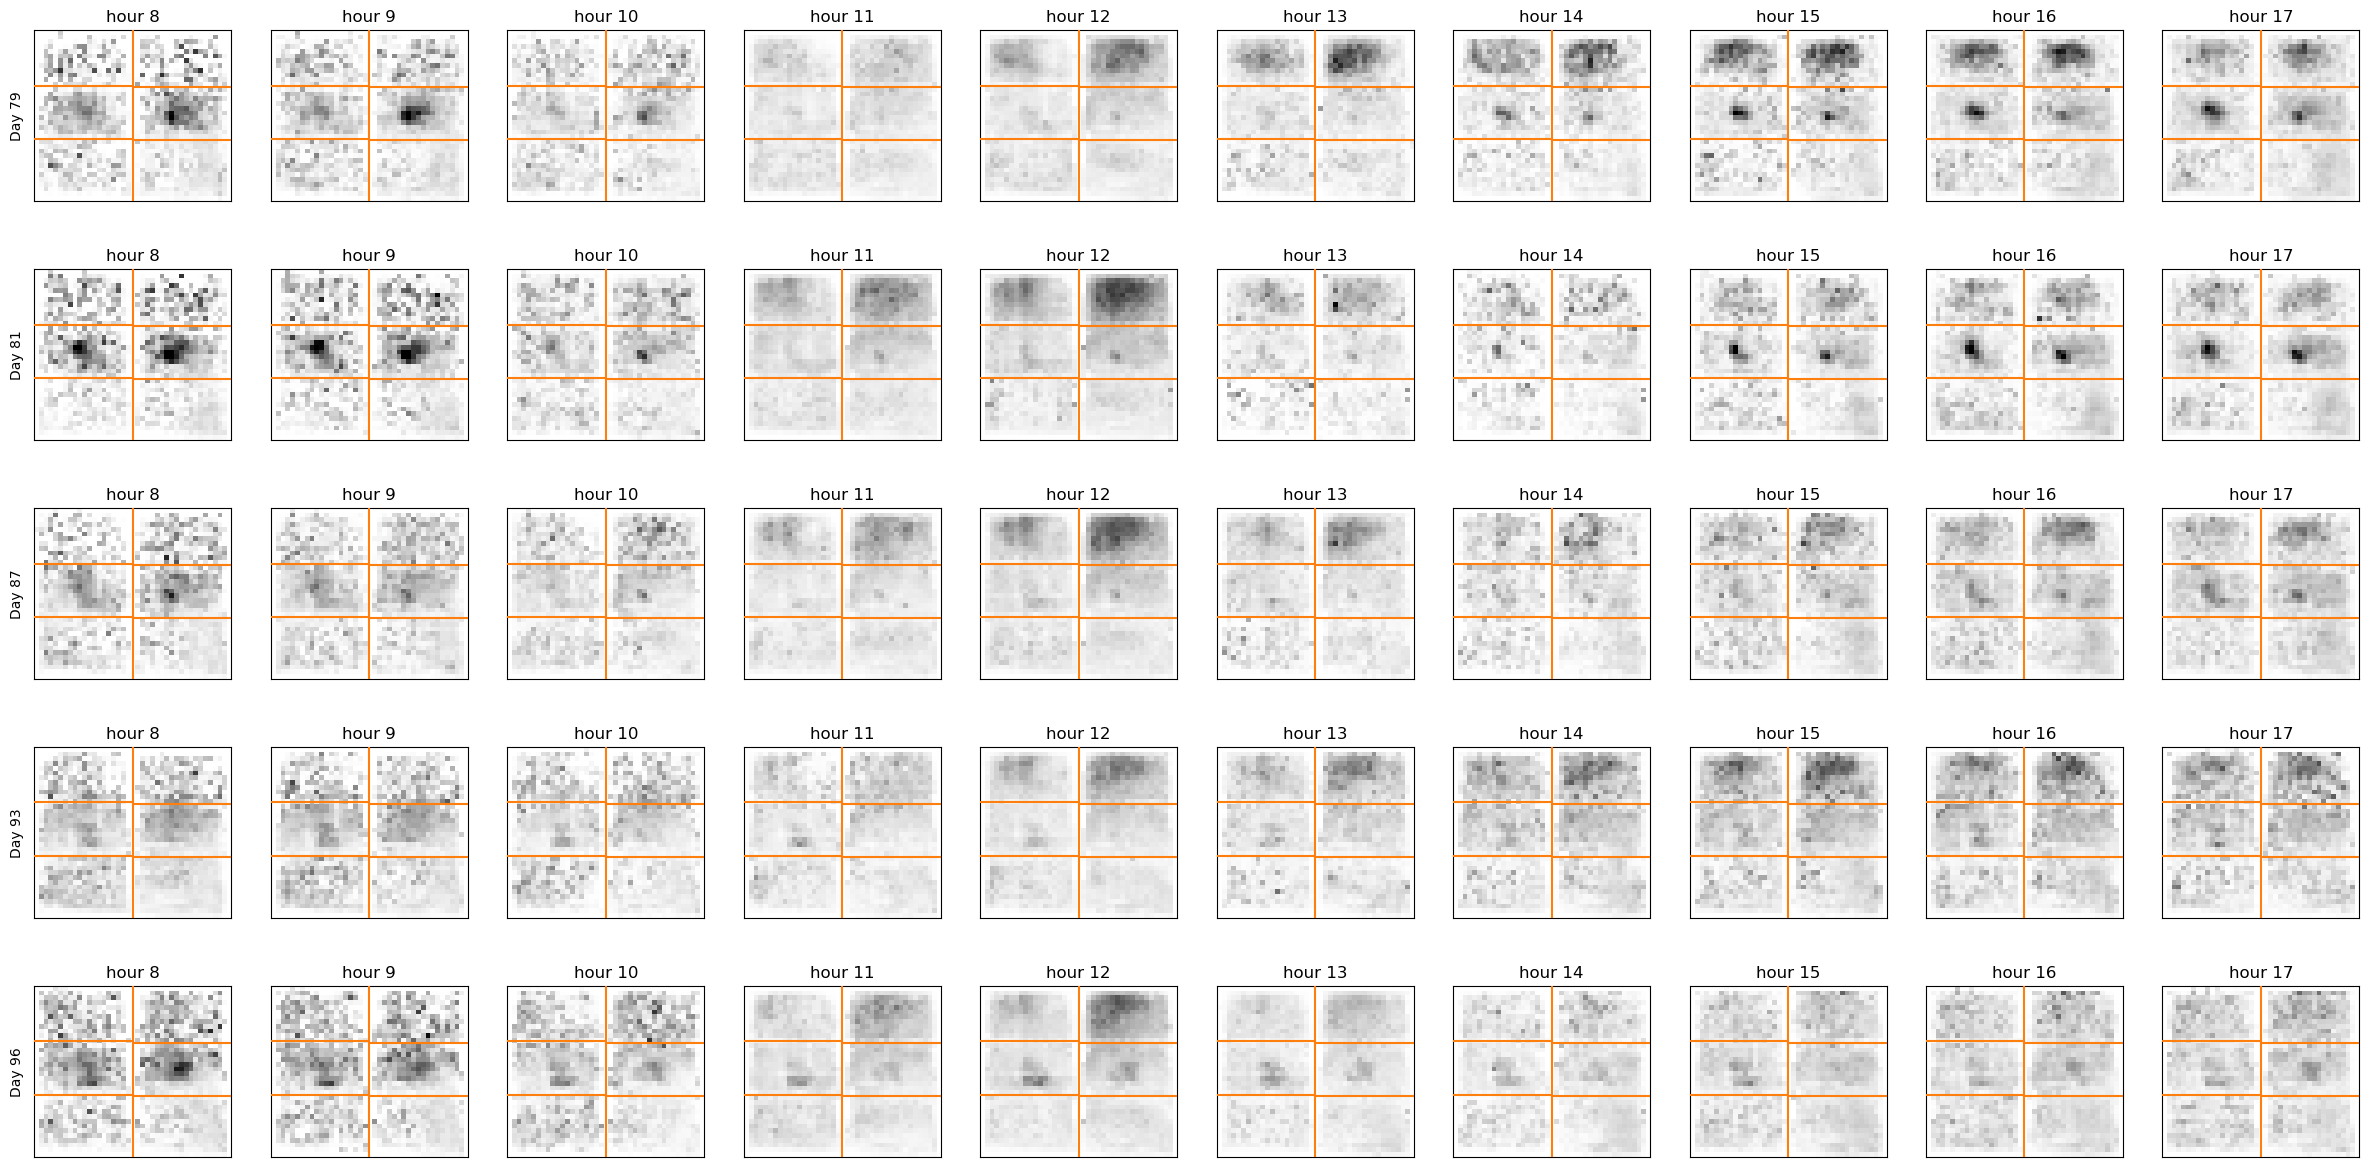

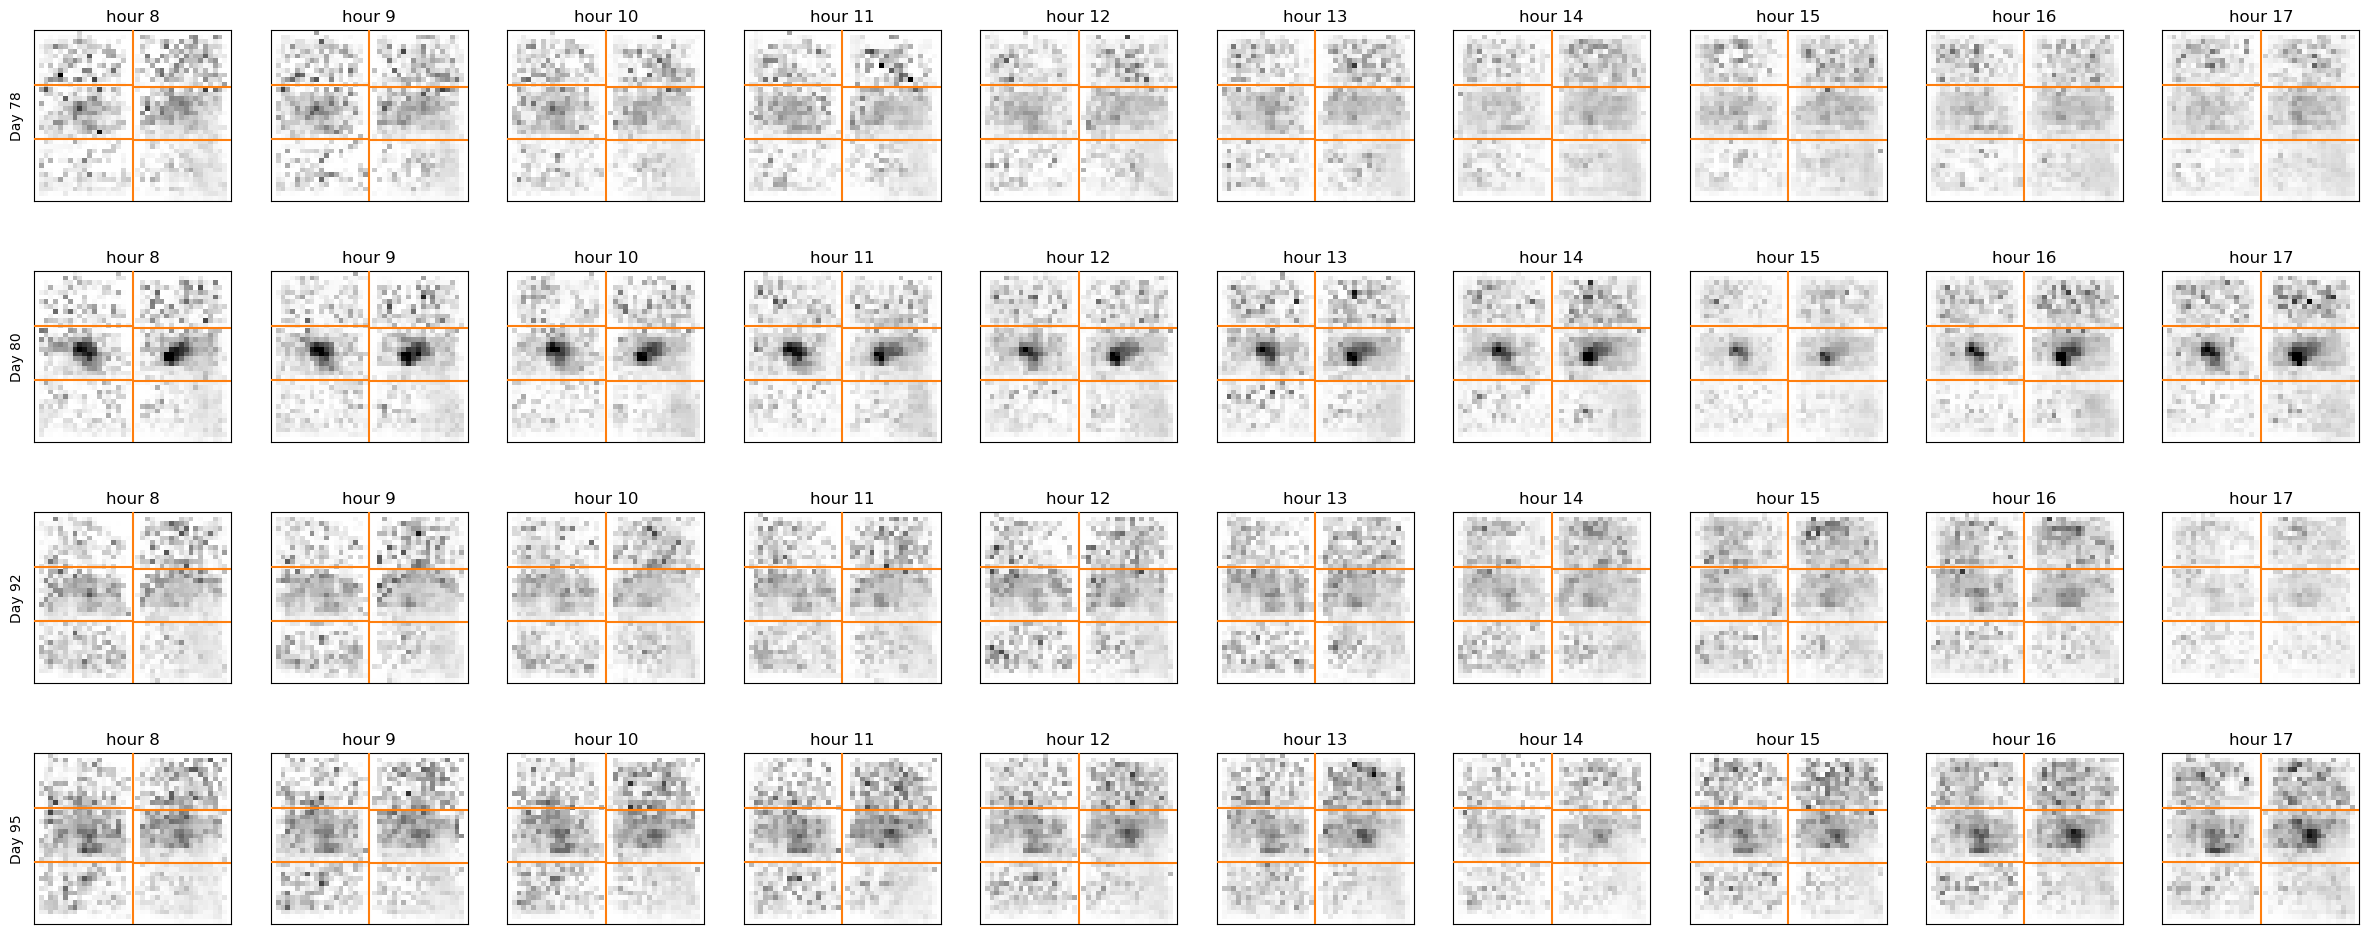

In [20]:
# plot certain hours of each day
days_to_show = treatmentdays

hournums = np.arange(8,18)

for days_to_show in [treatmentdays,controldays]:

    f,ax = plt.subplots(len(days_to_show),len(hournums),sharex=True,sharey=True)
    f.set_size_inches(ax.shape[1]*3,ax.shape[0]*3)
    f.set_facecolor('white')
    for i,daynum in enumerate(days_to_show):
        for j,hournum in enumerate(hournums):
            a=ax[i,j]
            sel = (dfxy['Day number']==daynum) & (dfxy['Hour']==hournum) 
            cohorthourhist = dfunc.flat_to_hist(np.mean(dfxy[sel],axis=0))
            bp.showframe(a)
            bp.showhist(cohorthourhist,ax=a,normvalue=14)
            a.set_title('hour '+str(hournum))
        ax[i,0].set_ylabel('Day '+str(daynum))
    plt.show()

In [159]:
c = sns.color_palette('husl',3)
colors_for_histograms = [c[2],c[0],c[1]]

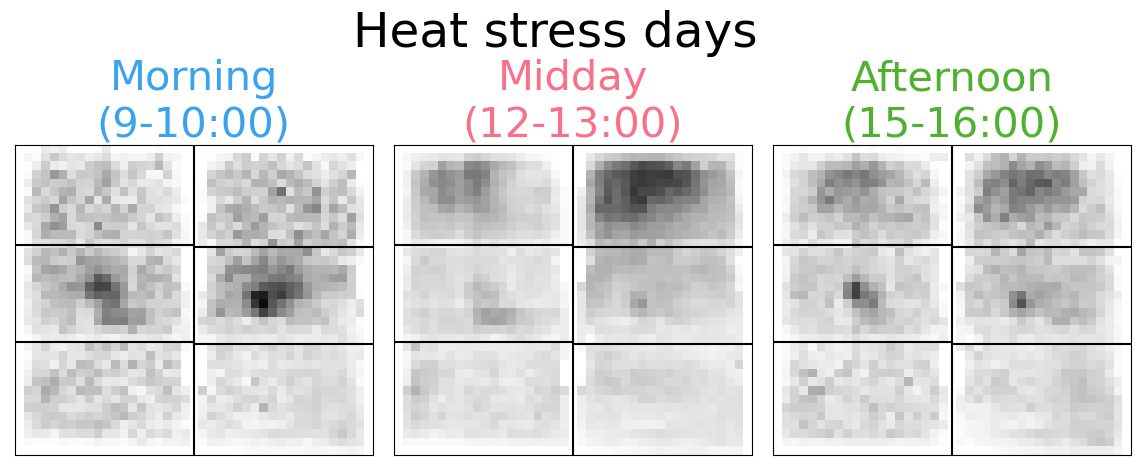

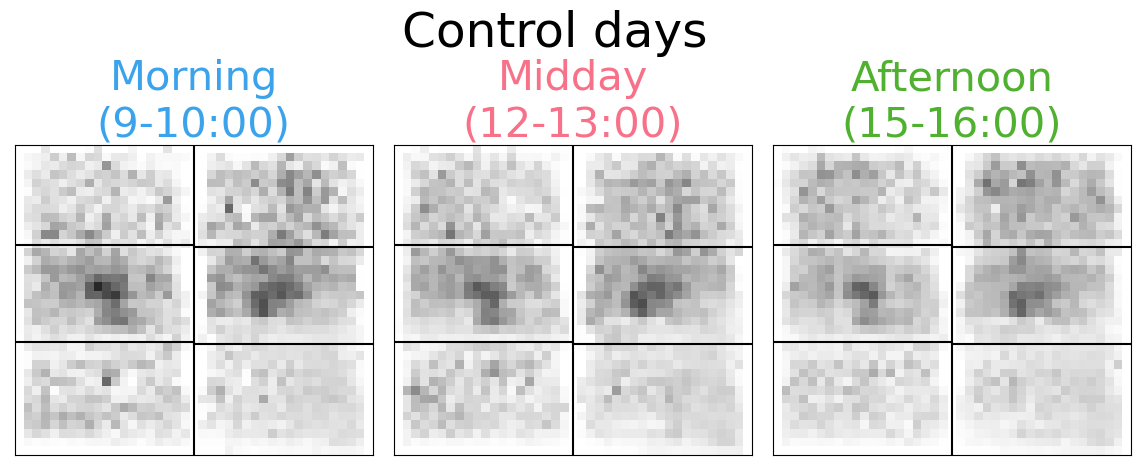

In [198]:
# plot certain hours of each day
hournums = [9,12,15]
for days_to_show,savename,title in zip([treatmentdays,controldays],['treatment','control'],['Heat stress days','Control days']):
    f,ax = plt.subplots(1,len(hournums),sharex=True,sharey=True)
    f.set_size_inches(ax.shape[0]*4.8,4.8)
    f.set_facecolor('white')

    for j, (hournum,hourname) in enumerate(zip(hournums,['Morning','Midday','Afternoon'])):
        cohorthourhist = []
        for i,daynum in enumerate(days_to_show):

            sel = (dfxy['Day number']==daynum) & (dfxy['Hour']==hournum) 
            cohorthourhist.append(dfunc.flat_to_hist(np.mean(dfxy[sel],axis=0)))
        cohorthourhist = np.nanmean(np.array(cohorthourhist),axis=0)
        # print(np.percentile(cohorthourhist,99)), print(np.max(cohorthourhist))
        a=ax[j]
        bp.showframe(a,color='k')
        bp.showhist(cohorthourhist,ax=a,normvalue=11)
        a.set_title(hourname+ '\n('+str(hournum)+'-'+str(hournum+1)+':00)',fontsize=30,color=colors_for_histograms[j])
    # ax[0].set_ylabel('Day '+str(daynum))
    plt.suptitle(title,fontsize=35,y=1.1)
    plt.subplots_adjust(wspace=0.06)
    plt.savefig('../image-output/fig3-densityhist_'+savename+'.pdf')
    plt.show()

# (Fig 2) Distributions

In [52]:
heatdaysel = df['Day number'].isin(treatmentdays)
controldaysel = df['Day number'].isin(controldays)

In [75]:
from matplotlib.ticker import MaxNLocator

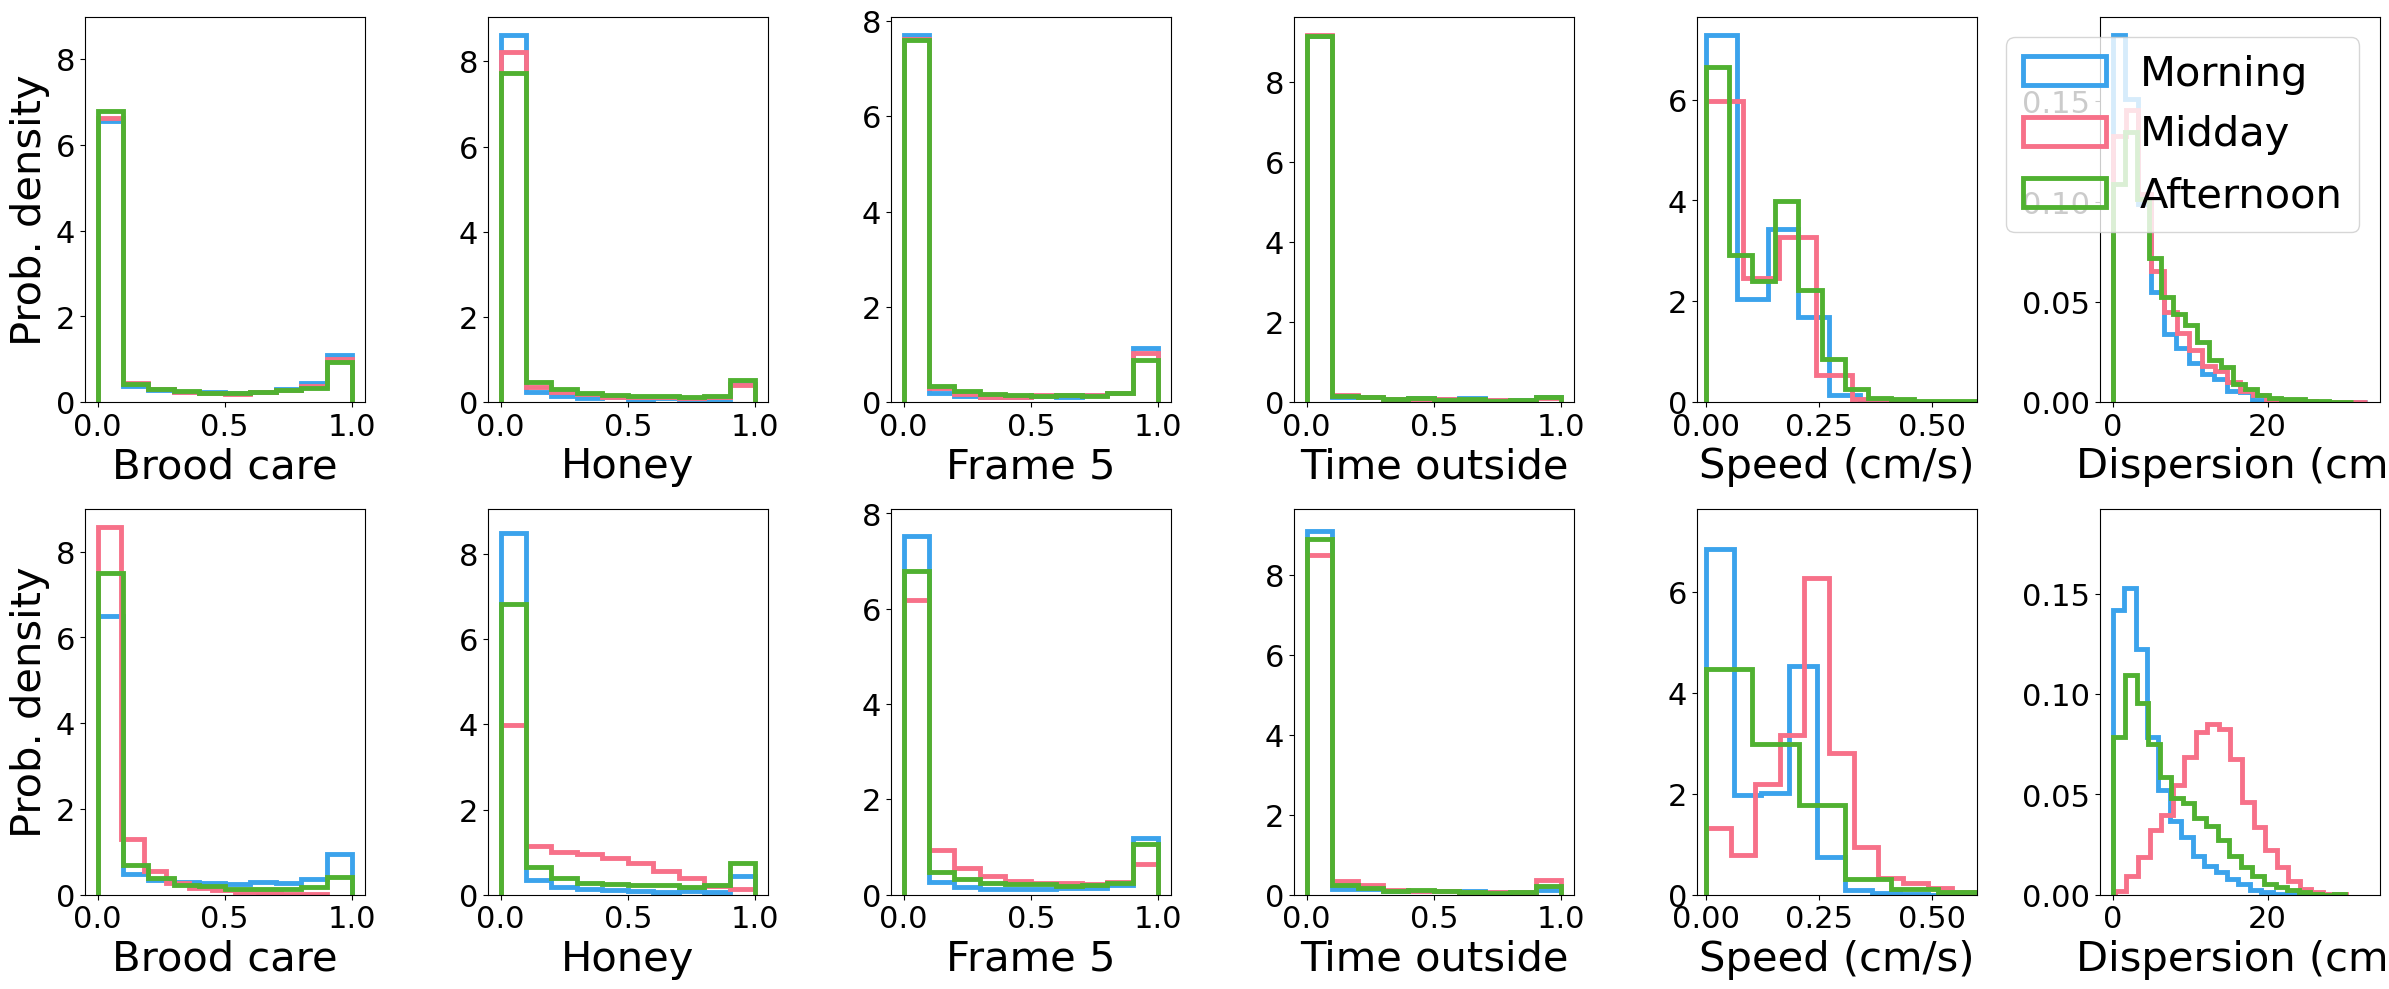

In [160]:
plotmetrics = ['Brood care', 'Honey', 'Frame 5', 'Out of hive fraction (day1min)', 'Median speed','Dispersion (avg)']
plotlabels = ['Brood care', 'Honey', 'Frame 5', 'Time outside', 'Speed (cm/s)', 'Dispersion (cm)']
f, ax = plt.subplots(2,6,sharex='col',sharey='col')
f.set_size_inches([6*4,10])
f.set_facecolor('white')

linewidth = 3.5
nbins = 20
for i,m in enumerate(plotmetrics):#range(datamat_all_days_stack.shape[1]):
    if (m in ['Median speed','Dispersion (avg)']):
        nbins = 20
    else:
        nbins = 10
    for j,hour in enumerate([9,12,15]):
        for k,daysel in enumerate([controldaysel,heatdaysel]):
            a=ax[k,i]
            msel = df.loc[daysel&(df['Hour']==hour),m]
            a.hist(msel,nbins,histtype='step',density=True,linewidth=linewidth,color=colors_for_histograms[j])

    if m == 'Median speed':
        ax[0,i].set_xlim([-0.02,0.6])
    # set tick formatting 
    for k in range(2):
        a=ax[k,i]
        a.xaxis.set_tick_params(which='both', labelbottom=True)  # turn ticks back on
        a.set_xlabel(plotlabels[i],fontsize=30)
        a.tick_params(labelsize=22)
        # a.yaxis.set_major_locator(MaxNLocator(4))
        # a.xaxis.set_major_locator(MaxNLocator(4))
        
        
ax[0,0].set_ylabel('Prob. density',fontsize=30)
ax[1,0].set_ylabel('Prob. density',fontsize=30)
ax[0,-1].legend(['Morning','Midday','Afternoon'],fontsize=30)
            
plt.tight_layout()
plt.savefig('../image-output/fig3-distributions_treatment_control.pdf')
plt.show()

# (Fig 2) Conditional movement

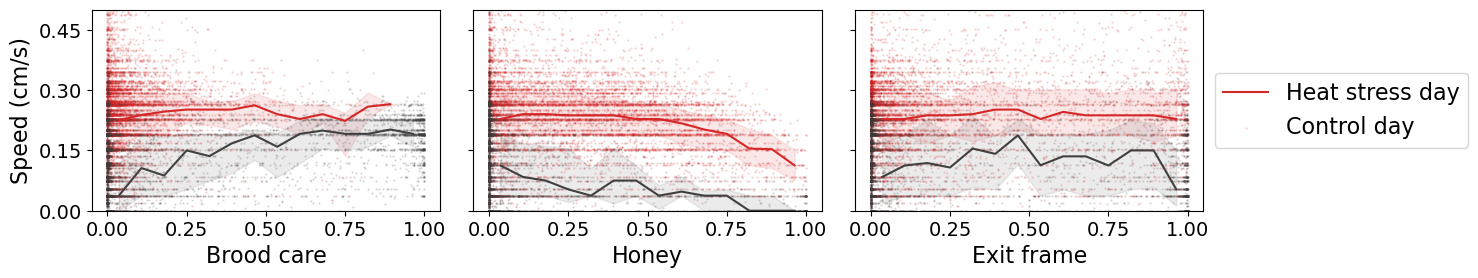

In [193]:
x_bins = np.linspace(0,1,15)
xtp = (x_bins[0:-1]+x_bins[1:])/2
xmetrics = ['Brood care','Honey','Frame 5']
xlabels = ['Brood care','Honey','Exit frame']
ymetric = 'Median speed'
ylabel = 'Speed (cm/s)'


f, ax = plt.subplots(1,len(xmetrics),sharey=True)
f.set_facecolor('white')
f.set_size_inches(len(xmetrics)*5,3)

for i,m in enumerate(xmetrics):
    # calculate heat quantiles
    x_heat, y_heat = df.loc[heatdaysel&(df['Hour']==12),[m,ymetric]].T.values
    nansel = np.logical_not(np.isnan(x_heat)|np.isnan(y_heat))
    heat_quantiles = [scipy.stats.binned_statistic(x_heat[nansel],y_heat[nansel],bins=x_bins,statistic=(lambda x: np.nanquantile(x,q)))[0] for q in [0.25,0.5,0.75]]
    # calculate control day quantiles
    x_ctrl, y_ctrl = df.loc[controldaysel&(df['Hour']==12),[m,ymetric]].T.values
    nansel = np.logical_not(np.isnan(x_ctrl)|np.isnan(y_ctrl))
    control_quantiles = [scipy.stats.binned_statistic(x_ctrl[nansel],y_ctrl[nansel],bins=x_bins,statistic=(lambda x: np.nanquantile(x,q)))[0] for q in [0.25,0.5,0.75]]

    
    a=ax[i]
    for qvals,c,x,y in zip([heat_quantiles,control_quantiles],[bp.snscolors[3],np.tile(0.25,3)],[x_heat,x_ctrl],[y_heat,y_ctrl]):
        a.plot(xtp, qvals[1],color=c)
        a.scatter(x,y,s=0.5,alpha=0.15,color=c,rasterized=True)
        a.fill_between(xtp,qvals[0],qvals[2],color=c,alpha=0.1)

    a.set_xlabel(xlabels[i],fontsize=16)
    a.yaxis.set_major_locator(MaxNLocator(4))
    a.set_ylim([0,0.5])
    a.tick_params(labelsize=14)
    
ax[-1].legend(['Heat stress day','Control day'],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=16)
ax[0].set_ylabel(ylabel,fontsize=16)
   
plt.tight_layout(pad = 1.5)
plt.savefig('../image-output/fig4-afternoon_vs_afternoon.pdf',bbox_inches='tight')
plt.show()

# (Figs 3-4):  PCA and embedding

In [9]:
savefigures = False
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('../image-output/'+'heatstress_embeddings.pdf')

In [10]:
morninghour = 9
middayhour = 12
afternoonhour = 15
hoursanalyzed = [morninghour,middayhour]

In [11]:
## construct PCA matrix
colsel = ['Num. observations','Out of hive fraction (day1min)', 'Num. outside trips (day1min)', 'Brood care','Honey', 
          'Frame 5', 'Exit distance (median)', 'Median speed', 'Dispersion (avg)', 'Fraction squares visited']

In [12]:
hoursel = np.any([df['Hour']==h for h in hoursanalyzed],axis=0)
daysel = np.any([df['Day number']==d for d in treatmentdays],axis=0)

In [13]:
dfsel = df[hoursel&daysel]
nanfilter = np.logical_not(np.any(np.isnan(dfsel[colsel]),axis=1))
dfsel = dfsel[nanfilter]

In [14]:
print('Number of unique bees included: ',len(np.unique(dfsel['Bee unique ID'])))
print('Number of behavioral hours included: ',dfsel.shape[0])

Number of unique bees included:  2974
Number of behavioral hours included:  20644


In [15]:
pcamat = dfsel[colsel].values
colmean = np.mean(pcamat,axis=0)
colstd = np.std(pcamat,axis=0)
pcamat = (pcamat-colmean)/colstd
pcacolnames = colsel

In [16]:
pcacolnames_forlabels = ['Time observed','Out of hive', 'Num. outside trips', 'Brood care', 'Honey', 'Exit frame','Exit distance','Median Speed','Dispersion', 'Frac. nest visited']

In [17]:
numev=pcamat.shape[1]
pca = PCA(n_components=numev).fit(pcamat)
vh = pca.components_
u = pca.transform(pcamat)
pcavar = pca.explained_variance_ratio_

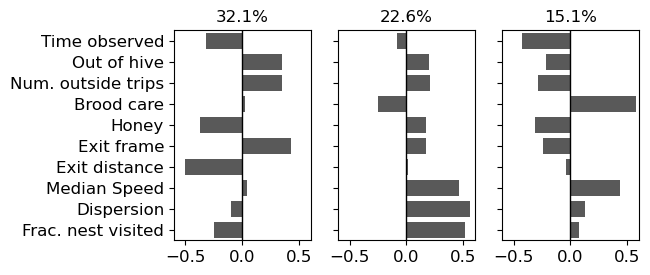

In [18]:
numev_toshow=3
f,ax = plt.subplots(1,numev_toshow,sharex=True,sharey=True)
scalesize=1
f.set_size_inches(2*numev_toshow*scalesize,3/11*len(pcacolnames)*scalesize)
bp.pcacomponentplots(ax,vh[:numev_toshow],pcacolnames_forlabels)
for j in range(numev_toshow):
    ax[j].set_title(str(round(pcavar[j]*100,1))+'%')
    
pdf.savefig(f) if savefigures else None    
plt.show()

In [19]:
timelabel = np.zeros(dfsel.shape[0])
for i,hour in enumerate(hoursanalyzed):
    timelabel[dfsel['Hour']==hour] = i

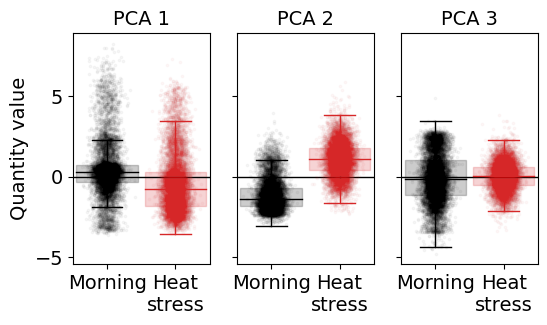

In [20]:
numev_toshow
f,ax = bp.quantitydists(2,timelabel,u[:,0:numev_toshow].T,['PCA '+str(p+1) for p in range(numev_toshow)],pointskip=1,color=['k',bp.snscolors[3]],coloroffset=100)
for a in ax:
    a.set_xlabel('',fontsize=14)
    a.set_xticks([0,1])
    a.set_xticklabels(['Morning','Heat\nstress'],fontsize=14)
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/morning-heat-pca.pdf')
plt.show()

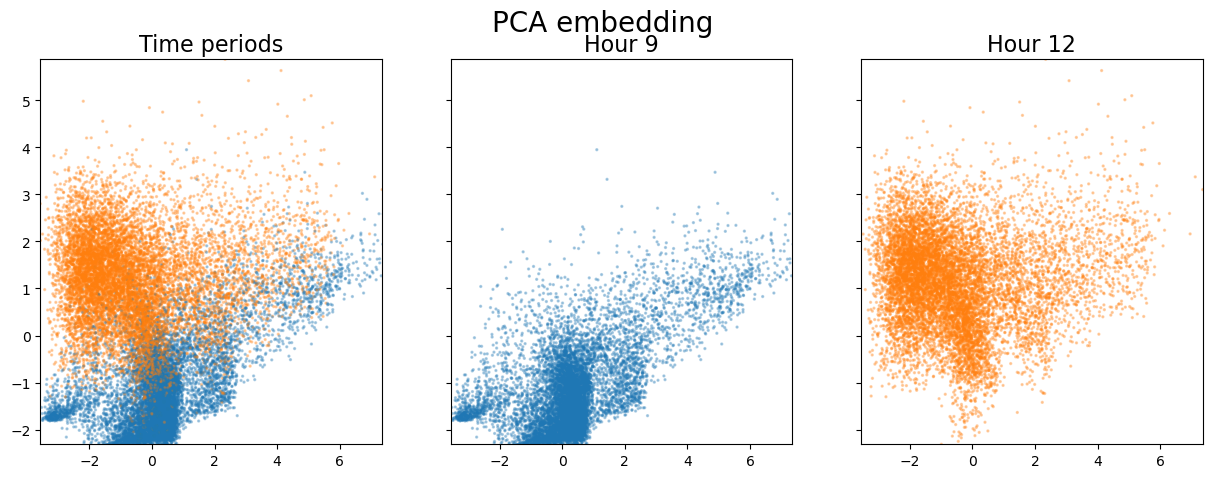

In [21]:
f,ax = plt.subplots(1,len(hoursanalyzed)+1,sharex=True,sharey=True)
basesize=5
f.set_size_inches(basesize*len(ax),basesize)
a=ax[0]
bp.plot_tsne_withcolors(a,u[:,0:2],timelabel,'Time periods',plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=0)
for i,hour in enumerate(hoursanalyzed):
    sel = (timelabel==i)
    a=ax[i+1]
    bp.plot_tsne_withcolors(a,u[sel,0:2],timelabel[sel],'Hour '+str(hour),plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=0)
plt.suptitle('PCA embedding', fontsize=20)
# pdf.savefig(f) if savefigures else None
plt.show()

1.0 58.0


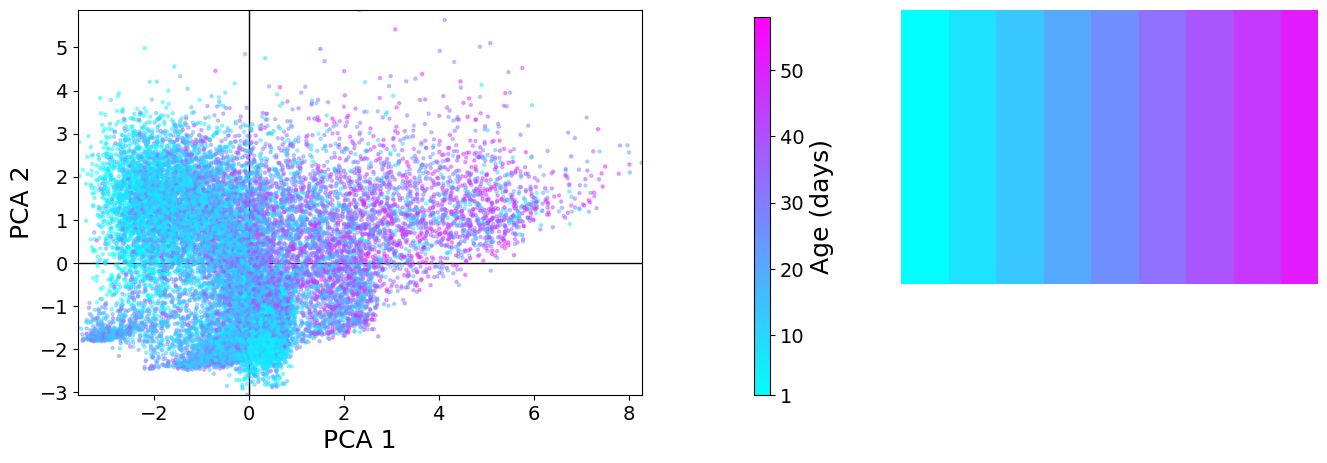

In [22]:
## PCA colored by age
tp = u
plotstyle='pca'  # pca or tsne
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
basesize=5
f.set_size_inches(16,5)

# plot
a=ax[0]
bp.plot_tsne_withcolors(a,tp,dfsel['Age'],'',plotskip=1,colortype='scalar',s=5,alphaval=0.4,coloroffset=0,qmin=0,qmax=1)
a.set_xlim([np.min(tp[:,0]),np.max(tp[:,0])])
a.set_ylim([np.min(tp[:,1]),np.max(tp[:,1])])
a.axvline(0,c='k',zorder=-1,linewidth=1)
a.axhline(0,c='k',zorder=-1,linewidth=1)    
a.tick_params(labelsize=14)
a.set_xlabel('PCA 1',fontsize=18)
a.set_ylabel('PCA 2',fontsize=18)
    
# legend-colorbar
a = ax[1]
a.axis('off')
minage, maxage = dfsel['Age'].min(), dfsel['Age'].max()
print(minage, maxage)
raster = a.pcolormesh(np.arange(10),np.arange(10),np.tile(np.linspace(minage,maxage,10),(10,1)),cmap='cool',vmin=minage,vmax=maxage,shading='nearest')
position=f.add_axes([a._position.bounds[0]+0.,a._position.bounds[1]+0.0,.01,0.755])
cbar=plt.colorbar(raster,ax=a,cax=position,orientation='vertical')    
cbar.set_label('Age (days)',fontsize=18)
ticks = np.arange(-5,5.5,1)
cbar.set_ticks([1,10,20,30,40,50])
# ticks=[str(t) for t in ticks]
# cbar.set_ticklabels(ticks)
cbar.ax.tick_params(labelsize=14)   
    
plt.savefig('../image-output/pca-age.pdf')
plt.show()

## Clustering on both

### Morning clustering

In [100]:
timesel = 0
morningsel = (timelabel==0)
heatsel = (timelabel==1)
print('hour for clustering: ',hoursanalyzed[timesel])
Zmorning = linkage(pcamat[timelabel==timesel],method='ward')

hour for clustering:  9


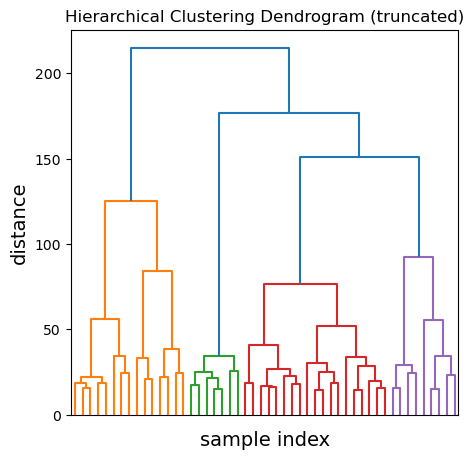

In [101]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index',fontsize=14)
plt.ylabel('distance',fontsize=14)
dendrogram(
    Zmorning,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False,  # to get a distribution impression in truncated branches
)
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/morningclustering.pdf')
plt.show()

In [102]:
# set n_clusters for using below
n_clusters_morning = 5

### heat stress clustering

In [103]:
start = time.time()
timesel =1
heatcoloroffset = n_clusters_morning
print('hour for clustering: ',hoursanalyzed[timesel])
Zheat = linkage(pcamat[timelabel==timesel],method='ward')

hour for clustering:  12


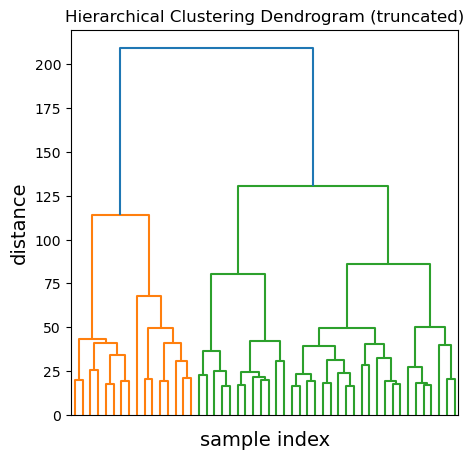

In [104]:
f,ax = plt.subplots(1,1)
f.set_size_inches(5,5)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index',fontsize=14)
plt.ylabel('distance',fontsize=14)
dendrogram(
    Zheat,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False,  # to get a distribution impression in truncated branches
)
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/heatclustering.pdf')
plt.show()

In [105]:
# set n_clusters for using below
n_clusters_heat = 4

In [106]:
# set both in clustering
dfmembership = dfsel[[]].copy()

## MORNING
dfclustering = dfsel[timelabel==0]
n_clusters = n_clusters_morning
membership = getmembership(n_clusters,Zmorning)
# switch indices M3 and M5, because then the numbers/interpretation connects better
mtemp = membership.copy()
membership[mtemp==2] = 4
membership[mtemp==4] = 2
del mtemp
# create a selector to accountfo the different days
# this is inefficient with the loop over all, but it works (couldn't think of something more elegant right now)
dfmembership['morningcluster'] = np.nan
for i in range(n_clusters):
    dftemp = dfclustering[membership==i]
    for j in range(len(dftemp)):
        d = dftemp.iloc[j]
        dfmembership.loc[(dfsel['Bee unique ID']==d['Bee unique ID']) & (dfsel['Day number']==d['Day number']),'morningcluster'] = i
        
## HEAT STRESS
dfclustering = dfsel[timelabel==1]
n_clusters = n_clusters_heat
membership = getmembership(n_clusters,Zheat)
# create a selector to accountfo the different days
# this is inefficient with the loop over all, but it works (couldn't think of something more elegant right now)
dfmembership['heatcluster'] = np.nan
for i in range(n_clusters):
    dftemp = dfclustering[membership==i]
    for j in range(len(dftemp)):
        d = dftemp.iloc[j]
        dfmembership.loc[(dfsel['Bee unique ID']==d['Bee unique ID']) & (dfsel['Day number']==d['Day number']),'heatcluster'] = i
        
        


In [107]:
print('fraction of bees observed in one period but not the other:',np.mean(np.any(np.isnan(dfmembership),axis=1)))

fraction of bees observed in one period but not the other: 0.033036233288122455


## Plots of results

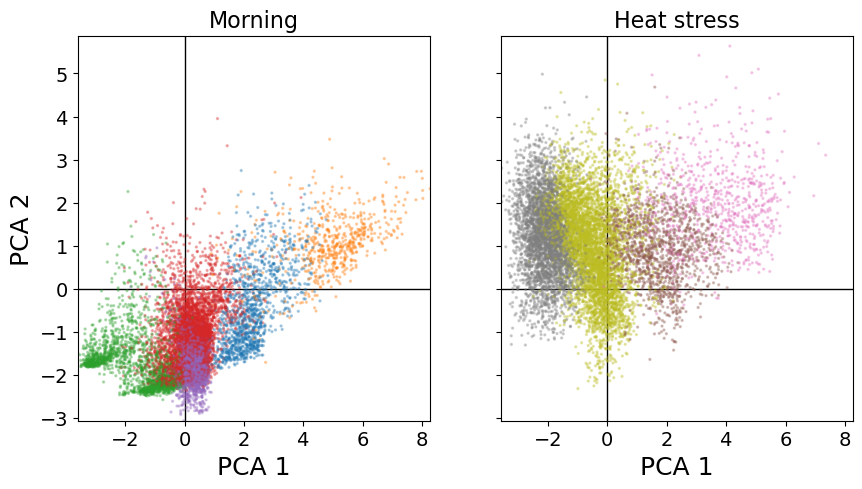

In [108]:
tp = u
plotstyle='pca'  # pca or tsne
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
basesize=5
f.set_size_inches(basesize*len(ax),basesize)
f.set_facecolor('white')
a=ax[0]
membership = dfmembership.loc[timelabel==0,'morningcluster']
bp.plot_tsne_withcolors(a,tp[morningsel,0:2],membership,'Morning',plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=0)
a=ax[1]
membership = dfmembership.loc[timelabel==1,'heatcluster']
bp.plot_tsne_withcolors(a,tp[heatsel,0:2],membership,'Heat stress',plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=heatcoloroffset)
if plotstyle=='tsne':
    [a.axis('off') for a in ax]
    a.set_xlim(xlim_tsne)
    a.set_ylim(ylim_tsne)
else:
    a.set_xlim([np.min(tp[:,0]),np.max(tp[:,0])])
    a.set_ylim([np.min(tp[:,1]),np.max(tp[:,1])])
    for a in ax:
        a.axvline(0,c='k',zorder=-1,linewidth=1)
        a.axhline(0,c='k',zorder=-1,linewidth=1)    
        a.tick_params(labelsize=14)
        a.set_xlabel('PCA 1',fontsize=18)
    ax[0].set_ylabel('PCA 2',fontsize=18)
    
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/pca-separate.pdf')
plt.show()

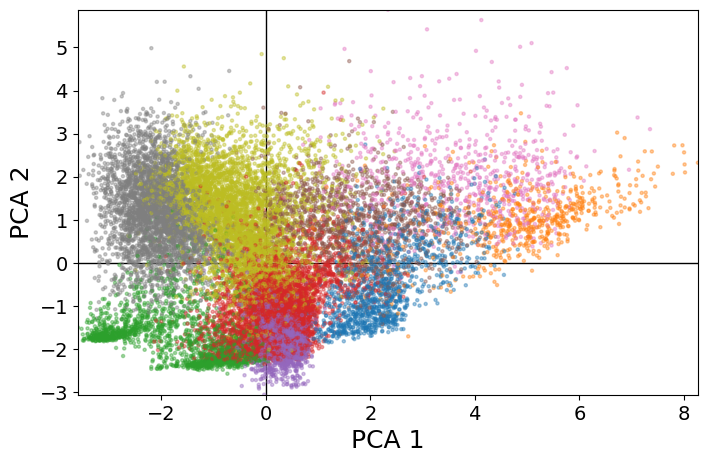

In [109]:
tp = u
plotstyle='pca'  # pca or tsne
f,ax = plt.subplots(1,1,sharex=True,sharey=True)
basesize=5
f.set_size_inches(8,5)
a=ax
membership1 = dfmembership.loc[timelabel==0,'morningcluster']
membership2 = dfmembership.loc[timelabel==1,'heatcluster'] + n_clusters_morning
membership = np.concatenate((membership1,membership2))
tpjoined = np.concatenate((tp[morningsel,0:2],tp[heatsel,0:2]))

# shuffle the points in order to make the display better, so the heat stress doesn't go too much on top
rng = np.random.default_rng()
inds = rng.permuted(np.arange(len(membership)))

bp.plot_tsne_withcolors(a,tpjoined[inds],membership[inds],'',plotskip=1,colortype='cat',s=5,alphaval=0.4,coloroffset=0)

a.set_xlim([np.min(tp[:,0]),np.max(tp[:,0])])
a.set_ylim([np.min(tp[:,1]),np.max(tp[:,1])])
a.axvline(0,c='k',zorder=-1,linewidth=1)
a.axhline(0,c='k',zorder=-1,linewidth=1)    
a.tick_params(labelsize=14)
a.set_xlabel('PCA 1',fontsize=18)
a.set_ylabel('PCA 2',fontsize=18)
    
plt.savefig('../image-output/pca-together.pdf')
plt.show()

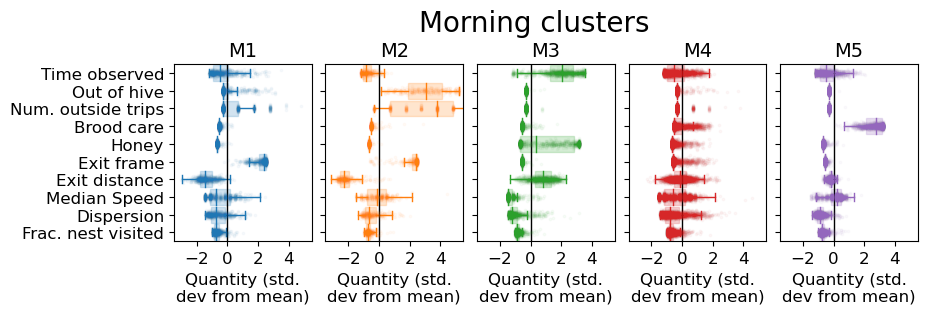

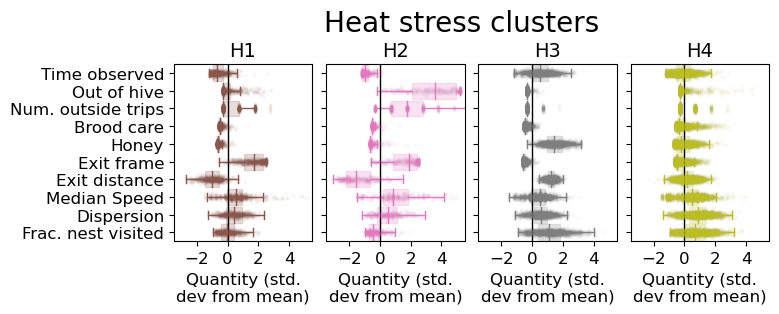

In [110]:
for pnum in [0,1]:
    f,ax = plt.subplots(1,[n_clusters_morning,n_clusters_heat][pnum],sharex=True,sharey=True)
    f.set_size_inches(2.4*ax.shape[0]*0.8,2.3)
    if pnum==0:
        bp.categorydists(n_clusters_morning,dfmembership.loc[timelabel==0,'morningcluster'],pcamat[morningsel].T,pcacolnames_forlabels,
                         pointskip=2,npoints_in_title=False,coloroffset=0,f=f,ax=ax)
        plt.suptitle("Morning clusters",fontsize=20,y=1.12)
    elif pnum==1:
        bp.categorydists(n_clusters_heat,dfmembership.loc[timelabel==1,'heatcluster'],pcamat[heatsel].T,pcacolnames_forlabels,
                                pointskip=2,npoints_in_title=False,coloroffset=heatcoloroffset,f=f,ax=ax)      
        plt.suptitle("Heat stress clusters",fontsize=20,y=1.12)
    ax[0].set_xlim([-3.5,5.5])
    plt.subplots_adjust(wspace=1.15)
    for i,a in enumerate(ax):
        a.set_xlabel('Quantity (std.\ndev from mean)',fontsize=12)
        a.tick_params(labelsize=12)
        a.set_xticks(np.arange(-2,6,2))
        a.set_title(['M','H'][pnum]+str(i+1),fontsize=14)
    plt.subplots_adjust(wspace=0.1)
    pdf.savefig(f) if savefigures else None
    plt.savefig('../image-output/temp'+str(pnum)+'.pdf')
    plt.show()

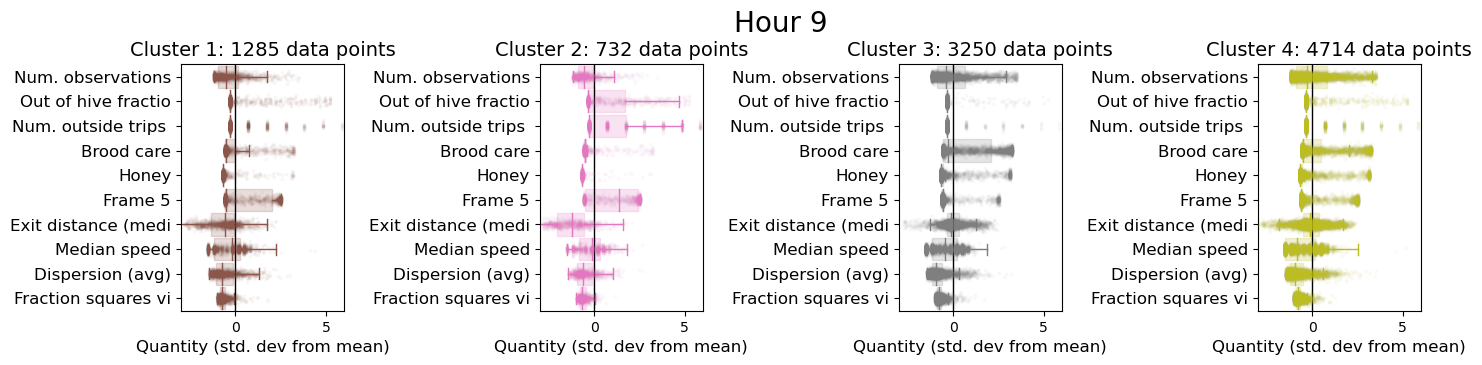

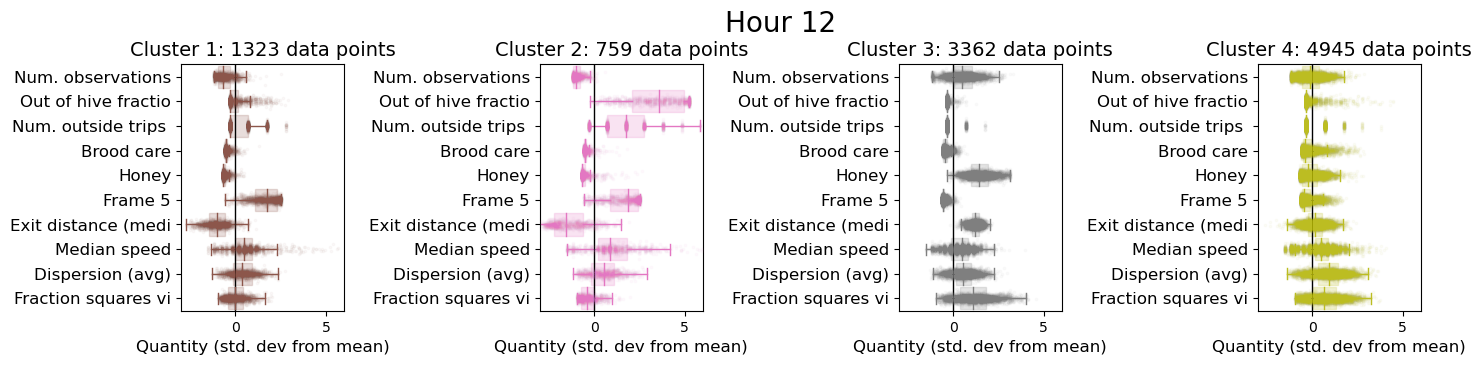

In [34]:
timesel=0
for timesel,hour in enumerate(hoursanalyzed):
    sel =  (dfsel['Hour']==hour) & np.logical_not(np.isnan(dfmembership['heatcluster']))
    f,ax = bp.categorydists(n_clusters,dfmembership.loc[sel,'heatcluster'].values,pcamat[sel].T,[p[0:19] for p in pcacolnames],pointskip=1,npoints_in_title=True,coloroffset=heatcoloroffset)
    ax[0].set_xlim([-3,6])
    plt.subplots_adjust(wspace=1.2)
    plt.suptitle('Hour '+str(hour),fontsize=20,y=1.05)
    plt.show()


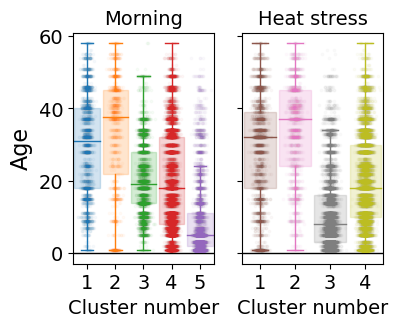

In [111]:
## Age distribution
f,ax = plt.subplots(1,2,sharex=False,sharey=True)
f.set_size_inches(2*2,3)
bp.quantitydists(n_clusters_morning,dfmembership['morningcluster'].values,[dfsel['Age'].values],['Morning'],pointskip=1,ax=[ax[0]])
bp.quantitydists(n_clusters_heat,dfmembership['heatcluster'].values,[dfsel['Age'].values],['Heat stress'],pointskip=1,ax=[ax[1]],coloroffset=n_clusters_morning)
ax[0].set_ylabel('Age',fontsize=16)
ax[1].set_ylabel('')
# for a in ax:
#     a.set_xlabel('',fontsize=14)
#     a.set_xticks([0,1])
#     a.set_xticklabels(['Morning','Heat\nstress'],fontsize=14)
pdf.savefig(f) if savefigures else None
plt.savefig('../image-output/heatstress-cluster-ages.pdf')

### Histogram plots

In [112]:
xysel = np.tile(False,len(dfxy))
dfxysel = pd.DataFrame()
for d in treatmentdays:
    temp = dfxy[dfxy['Day number']==d]
    temp = temp.loc[dfsel[(dfsel['Day number']==d)].index]
    dfxysel = pd.concat((dfxysel,temp))

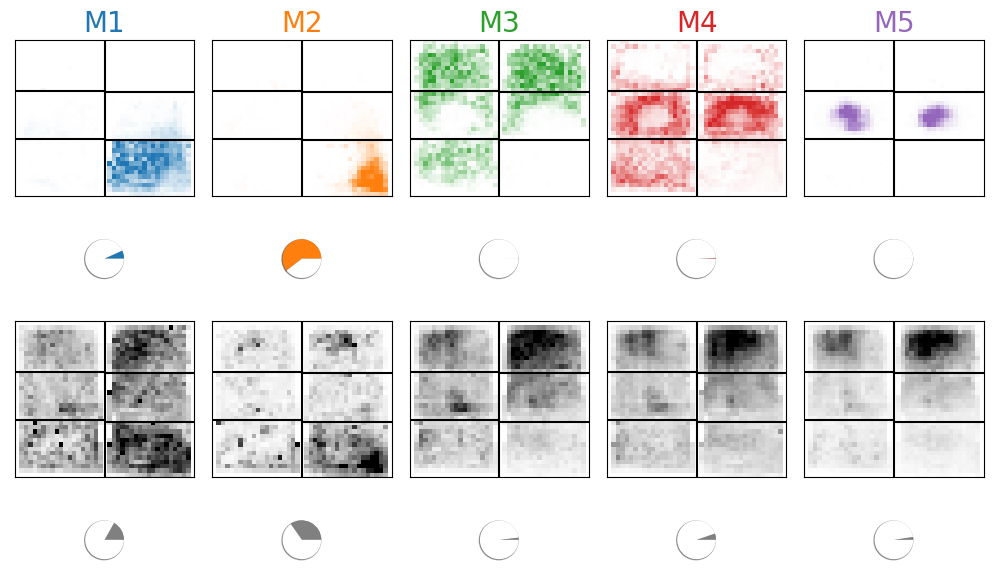

In [113]:
# plot morning clusters
f,ax = plt.subplots(4,(n_clusters_morning),sharex=False,sharey=False,
                    gridspec_kw={'height_ratios': [2.5,0.65,2.5,0.65]})
f.set_size_inches(n_clusters_morning*2.5,7)
f.set_facecolor('white')
for i in range(n_clusters_morning):
    a=ax[0,i]
    sel = (dfxysel['Hour']==morninghour)&(dfmembership['morningcluster']==i)
    tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
    bp.showframe(a,color='k')
    bp.showhist(tphist,ax=a,normvalue=-1,color=bp.snscolors[i])
    a.set_title('M'+str(i+1),fontsize=20,color=bp.snscolors[i])
    a=ax[1,i]
    timeout = np.mean(dfsel.loc[sel,'Out of hive fraction (day1min)'])
    a.pie([timeout,1-timeout],colors=[bp.snscolors[i],'white'],shadow=True)
    a=ax[2,i]
    sel = (dfxysel['Hour']==middayhour)&(dfmembership['morningcluster']==i)
    tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
    bp.showframe(a,color='k')
    bp.showhist(tphist,ax=a,normvalue=-1) 
    a=ax[3,i]
    timeout = np.mean(dfsel.loc[sel,'Out of hive fraction (day1min)'])
    a.pie([timeout,1-timeout],colors=['grey','white'],shadow=True)    
plt.subplots_adjust(wspace=0.1)
plt.savefig('../image-output/morning-heat.pdf')
plt.show()

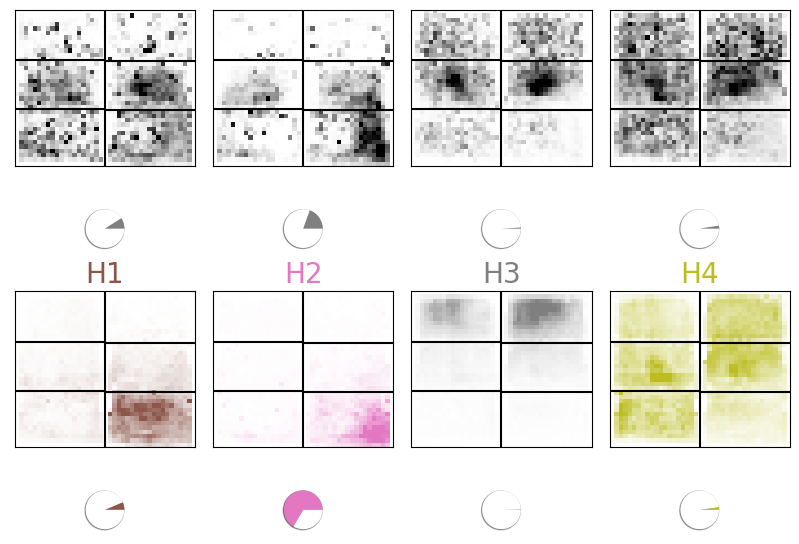

In [114]:
# plot heatstress clusters
f,ax = plt.subplots(4,(n_clusters_heat),sharex=False,sharey=False,
                    gridspec_kw={'height_ratios': [2.5,0.65,2.5,0.65]})
f.set_size_inches(n_clusters_morning*2,7)
f.set_facecolor('white')
for i in range(n_clusters_heat):
    a=ax[0,i]
    sel = (dfxysel['Hour']==morninghour)&(dfmembership['heatcluster']==i)
    tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
    bp.showframe(a,color='k')
    bp.showhist(tphist,ax=a,normvalue=-1)
    a=ax[1,i]
    timeout = np.mean(dfsel.loc[sel,'Out of hive fraction (day1min)'])
    a.pie([timeout,1-timeout],colors=['grey','white'],shadow=True)
    a=ax[2,i]
    a.set_title('H'+str(i+1),fontsize=20,color=bp.snscolors[i+heatcoloroffset])    
    sel = (dfxysel['Hour']==middayhour)&(dfmembership['heatcluster']==i)
    tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
    bp.showframe(a,color='k')
    bp.showhist(tphist,ax=a,normvalue=-1,color=bp.snscolors[i+heatcoloroffset])
    a=ax[3,i]
    timeout = np.mean(dfsel.loc[sel,'Out of hive fraction (day1min)'])
    a.pie([timeout,1-timeout],colors=[bp.snscolors[i+heatcoloroffset],'white'],shadow=True)        
plt.subplots_adjust(wspace=0.1)  # if 
plt.savefig('../image-output/heat-morning.pdf')
plt.show()

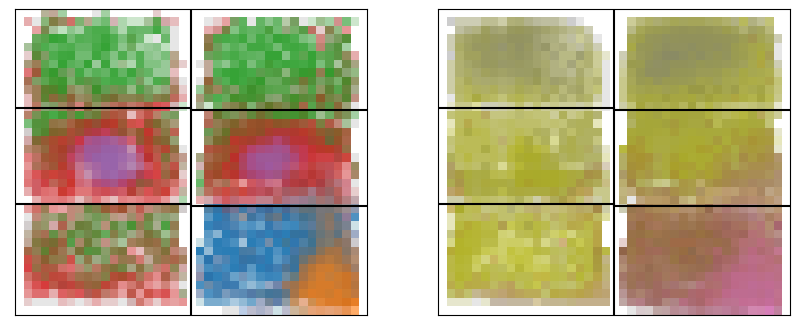

In [115]:
# plot heatstress clusters and morning clusters, merged
f,ax = plt.subplots(1,2)
f.set_size_inches(10,5)
f.set_facecolor('white')

rng = np.random.default_rng()

a=ax[0]
bp.showframe(a,color='k')
for j in range(25):
    for i in rng.permuted(np.arange(n_clusters_morning)):
        sel = (dfxysel['Hour']==morninghour)&(dfmembership['morningcluster']==i)
        tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
        bp.showhist(tphist,ax=a,normvalue=-1,color=bp.snscolors[i],alpha=0.1)

a=ax[1]
bp.showframe(a,color='k')
for j in range(25):
    for i in rng.permuted(np.arange(n_clusters_heat)):
        sel = (dfxysel['Hour']==middayhour)&(dfmembership['heatcluster']==i)
        tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
        bp.showhist(tphist,ax=a,normvalue=-1,color=bp.snscolors[i+heatcoloroffset],alpha=0.1)
plt.savefig('../image-output/clusters-merged.pdf',dpi=300)
plt.savefig('../image-output/clusters-merged.png',dpi=300)
plt.show()

Text(0.5, 1.0, 'Heat stress')

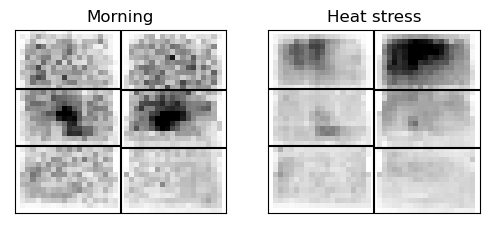

In [69]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
f.set_size_inches(6,3)
f.set_facecolor('white')

a=ax[0]
sel = (dfxysel['Hour']==morninghour)
tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
# print(np.quantile(tphist,0.99))
bp.showframe(a,color='k')
bp.showhist(tphist,ax=a,normvalue=-1)
a.set_title('Morning')

a=ax[1]
sel = (dfxysel['Hour']==middayhour)
tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
# print(np.quantile(tphist,0.99))
bp.showframe(a,color='k')
bp.showhist(tphist,ax=a,normvalue=-1)
a.set_title('Heat stress')

## Numbers moving between clusters

In [117]:
## simple fractions
# with numbers, just need a single matrix
def get_morning_to_heat_num(dfmembership):
    morning_to_heat_num = np.tile(np.nan,(n_clusters_morning,n_clusters_heat))
    for i in range(n_clusters_morning):
        sel = dfmembership[(dfmembership['morningcluster']==i)&np.logical_not(np.isnan(dfmembership['heatcluster']))]
        for j in range(n_clusters_heat):
            morning_to_heat_num[i,j] = np.sum(sel['heatcluster']==j)
    return morning_to_heat_num
morning_to_heat_num = get_morning_to_heat_num(dfmembership)

In [118]:
n_percluster_morning = np.sum(morning_to_heat_num,axis=1)
n_percluster_heat = np.sum(morning_to_heat_num,axis=0)
frac_percluster_morning = n_percluster_morning/np.sum(n_percluster_morning)
frac_percluster_heat = n_percluster_heat/np.sum(n_percluster_heat)

In [119]:
## fractions, based on numbers in other clusters
totalcounts = np.sum(morning_to_heat_num)
# if np.sum(morning_to_heat_num)!=np.sum(heat_to_morning_num):
#     print('Check calculation - something is wrong')
morning_to_heat_frac = morning_to_heat_num / totalcounts
expectedfracs = frac_percluster_morning[:,np.newaxis]*frac_percluster_heat[np.newaxis,:]
expectednums = expectedfracs*totalcounts

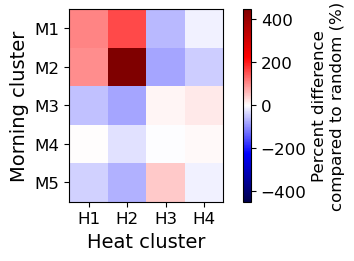

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

tp_mh = (morning_to_heat_num - expectednums) / expectednums * 100

maxboth = np.max(np.abs((tp_mh)))
minboth = -maxboth

# plt.imshow([morning_to_heat_num[0]],vmin=0,vmax=maxboth)
# plt.show()
f,ax=plt.subplots(1,1,sharex=True,sharey=True)
f.set_size_inches(2.5,2.5)
a=ax
im = a.imshow(tp_mh,vmin=minboth,vmax=maxboth,cmap="seismic")
a.set_xticks(range(n_clusters_heat))
a.set_xticklabels(['H'+str(i+1) for i in range(n_clusters_heat)],fontsize=12)
a.set_yticks(range(n_clusters_morning))
a.set_yticklabels(['M'+str(i+1) for i in range(n_clusters_morning)],fontsize=12)
a.set_ylabel('Morning cluster',fontsize=14)
a.set_xlabel('Heat cluster',fontsize=14)
divider = make_axes_locatable(a)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = f.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=12) 
cbar.ax.set_ylabel('Percent difference\ncompared to random (%)',fontsize=12)
plt.savefig('../image-output/clusterfracs-percentdiff.pdf')
plt.show()

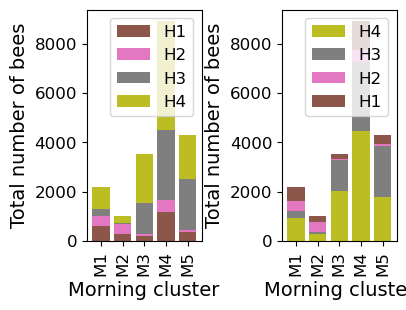

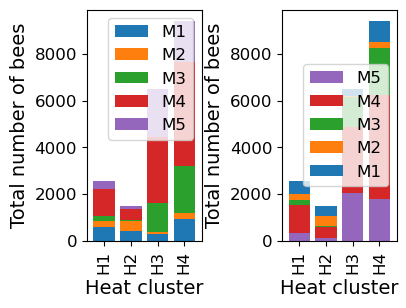

In [121]:
# make a stacked bar chart
heatnames = ['H'+str(i+1) for i in range(n_clusters_heat)]
morningnames = ['M'+str(i+1) for i in range(n_clusters_morning)]
dftp = pd.DataFrame(morning_to_heat_num,columns=heatnames)
dftp.insert(0,'morning',morningnames)

f,ax = plt.subplots(1,2)
f.set_size_inches(4,3)
a=ax[0]
dftp.set_index('morning').plot(kind='bar', stacked=True, color=bp.snscolors[heatcoloroffset:heatcoloroffset+n_clusters_heat],ax=a,width=0.8)
a=ax[1]
dftp.set_index('morning')[np.flip(heatnames)].plot(kind='bar', stacked=True, color=np.flip(bp.snscolors[heatcoloroffset:heatcoloroffset+n_clusters_heat],axis=0),ax=a,width=0.8)

for a in ax:
    a.tick_params(labelsize=12)    
    a.set_xlabel('Morning cluster',fontsize=14)
    a.set_ylabel('Total number of bees',fontsize=14)
    a.legend(fontsize=12)

plt.subplots_adjust(wspace=0.7)
plt.savefig('../image-output/stackedvbar-frommorning.pdf')
plt.show()


####

dftpt = dftp.T
dftpt.columns = dftpt.iloc[0]
dftpt = dftpt.drop('morning')

f,ax = plt.subplots(1,2)
f.set_size_inches(4,3)
a=ax[0]
dftpt.plot(kind='bar', stacked=True, color=bp.snscolors[0:0+n_clusters_morning],ax=a,width=0.8)
a=ax[1]
dftpt[np.flip(morningnames)].plot(kind='bar', stacked=True, color=np.flip(bp.snscolors[0:0+n_clusters_morning],axis=0),ax=a,width=0.8)

for a in ax:
    a.tick_params(labelsize=12)    
    a.set_xlabel('Heat cluster',fontsize=14)
    a.set_ylabel('Total number of bees',fontsize=14)
    a.legend(fontsize=12)

plt.subplots_adjust(wspace=0.7)
plt.savefig('../image-output/stackedvbar-fromheat.pdf')
plt.show()

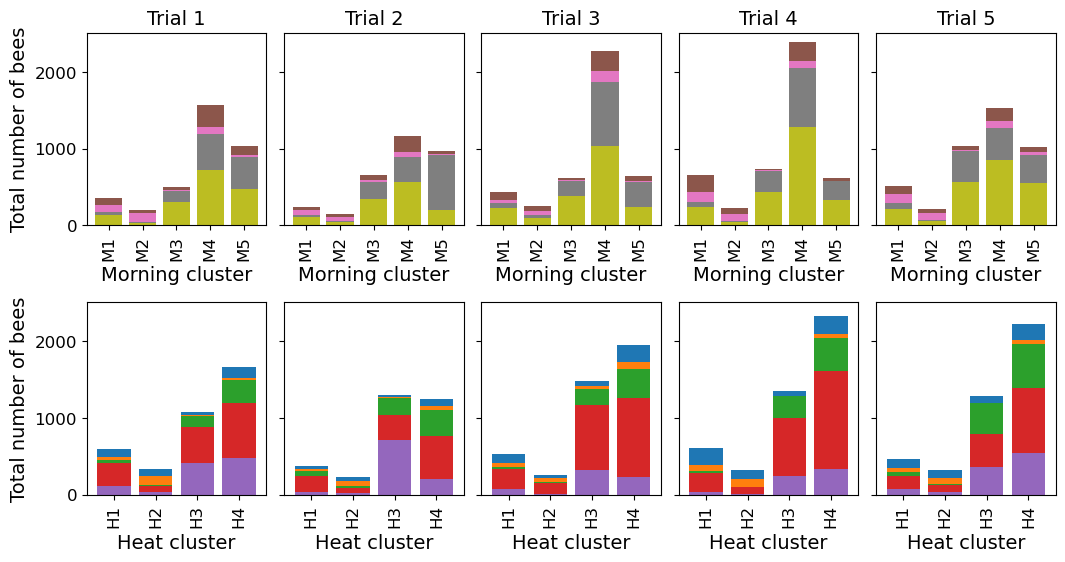

In [122]:
## put together, without legend (to be copied from above
flip = True
f,ax = plt.subplots(2,len(treatmentdays),sharey=True)
f.set_size_inches(2.5*5,6)

for i,daynum in enumerate(treatmentdays):
    
    sel = dfxysel['Day number']==daynum
    nums = get_morning_to_heat_num(dfmembership[sel])
    dftp = pd.DataFrame(nums,columns=heatnames)
    dftp.insert(0,'morning',morningnames)    
    
    dftpt = dftp.T
    dftpt.columns = dftpt.iloc[0]
    dftpt = dftpt.drop('morning')

    a=ax[0,i]
    if flip:
        dftp.set_index('morning')[np.flip(heatnames)].plot(kind='bar', stacked=True, color=np.flip(bp.snscolors[heatcoloroffset:heatcoloroffset+n_clusters_heat],axis=0),ax=a,width=0.8)
    else:
        dftp.set_index('morning').plot(kind='bar', stacked=True, color=bp.snscolors[heatcoloroffset:heatcoloroffset+n_clusters_heat],ax=a,width=0.8)
    a.set_xlabel('Morning cluster',fontsize=14)

    a=ax[1,i]
    if flip:
        dftpt[np.flip(morningnames)].plot(kind='bar', stacked=True, color=np.flip(bp.snscolors[0:0+n_clusters_morning],axis=0),ax=a,width=0.8)    
    else:
        dftpt.plot(kind='bar', stacked=True, color=bp.snscolors[0:0+n_clusters_morning],ax=a,width=0.8)
    a.set_xlabel('Heat cluster',fontsize=14)
    
    ax[0,i].set_title('Trial '+str(i+1),fontsize=14)
for a in ax.flatten():
    a.tick_params(labelsize=12)    
    a.get_legend().remove()
    
[ax[i,0].set_ylabel('Total number of bees',fontsize=14) for i in range(2)]


plt.subplots_adjust(wspace=0.1,hspace=0.4)
plt.savefig('../image-output/stackedbar-perday.pdf')
plt.show()

In [130]:
dftable = dftp.set_index('morning')
dftable['M-total'] = dftable.sum(axis=1)
temp = dftable.sum(axis=0)
dftable = pd.concat((dftable,pd.DataFrame([temp])))
dftable = dftable.astype(int)
dftable

H1   H2    H3    H4  M-total
M1  110  106    80   214      510
M2   50   86    10    58      204
M3   52    8   400   568     1028
M4  172   88   426   848     1534
M5   76   36   366   546     1024
0   460  324  1282  2234     4300

In [131]:
print(dftable.style.to_latex()) 

\begin{tabular}{lrrrrr}
 & H1 & H2 & H3 & H4 & M-total \\
M1 & 110 & 106 & 80 & 214 & 510 \\
M2 & 50 & 86 & 10 & 58 & 204 \\
M3 & 52 & 8 & 400 & 568 & 1028 \\
M4 & 172 & 88 & 426 & 848 & 1534 \\
M5 & 76 & 36 & 366 & 546 & 1024 \\
0 & 460 & 324 & 1282 & 2234 & 4300 \\
\end{tabular}



## PCA embeddings from morning to midday

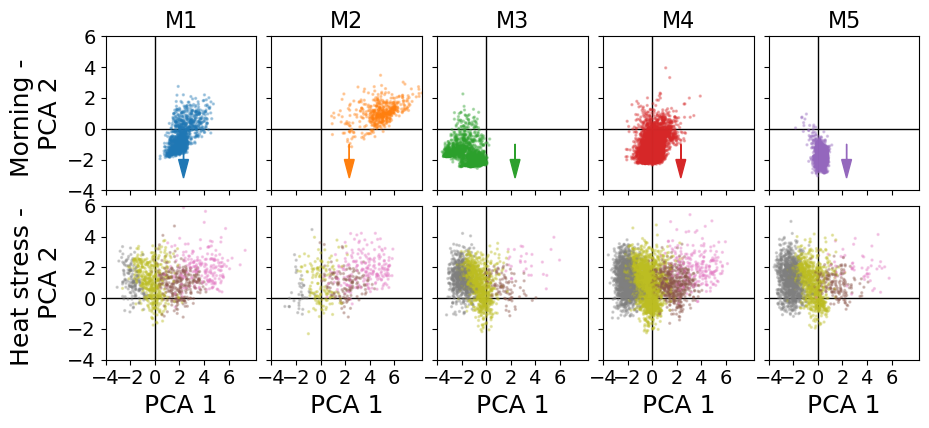

In [136]:
## Morning to heat stress
basesize=2.1
plotstyle='pca'
toplot = u
n_clusters = n_clusters_morning

f,ax = plt.subplots(len(hoursanalyzed),n_clusters,sharex=True,sharey=True)
f.set_size_inches(basesize*n_clusters,basesize*ax.shape[0])
f.set_facecolor('white')

xlims = [np.min(toplot[:,0]),np.max(toplot[:,0])]

# morning time:  clusters one per each
for i in range(n_clusters):
    a=ax[0,i]
    sel = (dfmembership['morningcluster']==i) & (dfsel['Hour']==morninghour) & np.logical_not(np.any(np.isnan(dfmembership),axis=1))
    tp = toplot[sel,0:2]
    bp.plot_tsne_withcolors(a,tp[:,0:2],dfmembership.loc[sel,'morningcluster'],'M'+str(i+1),plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=0)
    a.arrow(np.mean(xlims),-1,0,-1,head_width=0.8,color=bp.snscolors[i])
    a=ax[1,i]
    sel = (dfmembership['morningcluster']==i) & (dfsel['Hour']==middayhour) & np.logical_not(np.any(np.isnan(dfmembership),axis=1))
    tp = toplot[sel,0:2]    
    bp.plot_tsne_withcolors(a,tp[:,0:2],dfmembership.loc[sel,'heatcluster'],'',plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=heatcoloroffset)

# formatting
if plotstyle=='tsne':
    [a.axis('off') for a in ax.flatten()]
    a=ax[0,0]
    a.set_xlim(xlim_tsne)
    a.set_ylim(ylim_tsne)
else:
    a=ax[0,0]
    a.set_xlim(xlims)
    a.set_ylim([np.min(toplot[:,1]),np.max(toplot[:,1])])
    for a in ax.flatten():
        a.axvline(0,c='k',zorder=-1,linewidth=1)
        a.axhline(0,c='k',zorder=-1,linewidth=1)    
        a.tick_params(labelsize=14)
    for a in ax[-1]:
        a.set_xlabel('PCA 1',fontsize=18)
        a.set_xticks(np.arange(-4,8,2))
        a.set_yticks(np.arange(-4,8,2))        
    ax[0,0].set_ylabel('Morning - \nPCA 2',fontsize=18)
    ax[1,0].set_ylabel('Heat stress - \nPCA 2',fontsize=18)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig('../image-output/htemp1.pdf')
pdf.savefig(f) if savefigures else None
plt.show()

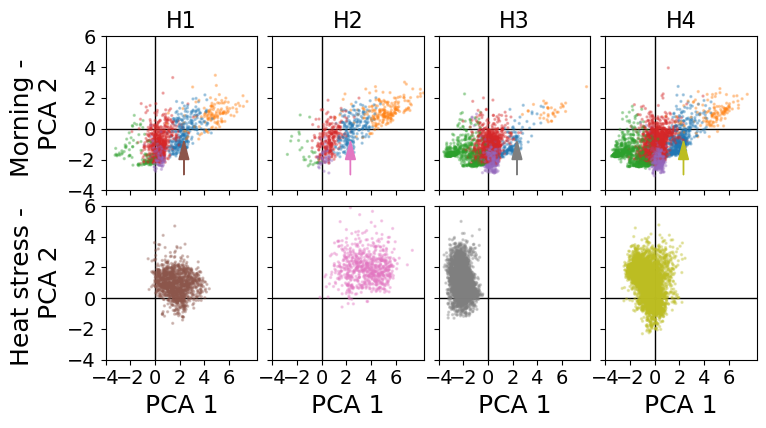

In [137]:
## Heat stress to morning

basesize=2.1
plotstyle='pca'
toplot = u
n_clusters = n_clusters_heat

f,ax = plt.subplots(len(hoursanalyzed),n_clusters,sharex=True,sharey=True)
f.set_size_inches(basesize*n_clusters,basesize*ax.shape[0])
f.set_facecolor('white')

xlims = [np.min(toplot[:,0]),np.max(toplot[:,0])]

# morning time:  clusters one per each
for i in range(n_clusters):
    a=ax[0,i]
    sel = (dfmembership['heatcluster']==i) & (dfsel['Hour']==morninghour) & np.logical_not(np.any(np.isnan(dfmembership),axis=1))
    tp = toplot[sel,0:2]
    bp.plot_tsne_withcolors(a,tp[:,0:2],dfmembership.loc[sel,'morningcluster'],'H'+str(i+1),plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=0)
    a.arrow(np.mean(xlims),-3,0,1,head_width=0.8,color=bp.snscolors[i+heatcoloroffset])
    a=ax[1,i]
    sel = (dfmembership['heatcluster']==i) & (dfsel['Hour']==middayhour) & np.logical_not(np.any(np.isnan(dfmembership),axis=1))
    tp = toplot[sel,0:2]    
    bp.plot_tsne_withcolors(a,tp[:,0:2],dfmembership.loc[sel,'heatcluster'],'',plotskip=1,colortype='cat',s=2,alphaval=0.3,coloroffset=heatcoloroffset)

# formatting
ax[0,0].set_ylabel('Morning',fontsize=20)
ax[1,0].set_ylabel('Heat stress',fontsize=20)
if plotstyle=='tsne':
    [a.axis('off') for a in ax.flatten()]
    a=ax[0,0]
    a.set_xlim(xlim_tsne)
    a.set_ylim(ylim_tsne)
else:
    a=ax[0,0]
    a.set_xlim([np.min(toplot[:,0]),np.max(toplot[:,0])]) 
    a.set_ylim([np.min(toplot[:,1]),np.max(toplot[:,1])])
    for a in ax.flatten():
        a.axvline(0,c='k',zorder=-1,linewidth=1)
        a.axhline(0,c='k',zorder=-1,linewidth=1)    
        a.tick_params(labelsize=14)
    for a in ax[-1]:
        a.set_xlabel('PCA 1',fontsize=18)
        a.set_xticks(np.arange(-4,8,2))
        a.set_yticks(np.arange(-4,8,2))        
    ax[0,0].set_ylabel('Morning - \nPCA 2',fontsize=18)
    ax[1,0].set_ylabel('Heat stress - \nPCA 2',fontsize=18)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.savefig('../image-output/htemp2.pdf')
pdf.savefig(f) if savefigures else None
plt.show()

In [226]:
pdf.close() if savefigures else None
savefigures=False

# Correlation over time

In [8]:
uids = np.unique(df['Bee unique ID'])

print(controldays)

print(treatmentdays)

[78 80 92 95]
[79 81 87 93 96]


In [23]:
numhoursforward = 25
starthour = morninghour

corrheatdays = treatmentdays
# corrcomparedays = treatmentdays[1:]+1
corrcomparedays = controldays

corrmat_heat = np.tile(np.nan,(numhoursforward,len(treatmentdays),len(uids),len(colsel)))
corrmat_compare = np.tile(np.nan,(numhoursforward,len(corrcomparedays),len(uids),len(colsel)))

for unum,uid in enumerate(uids):
    dfbee = df[df['Bee unique ID']==uid]
    for i,daynum in enumerate(corrheatdays):
        startint = (daynum - firstday)*24 + starthour
        endint = (daynum - firstday)*24 + starthour + numhoursforward
        vals = dfbee.loc[(dfbee['HourInteger']>=startint)&(dfbee['HourInteger']<endint),colsel].values
        corrmat_heat[0:vals.shape[0],i,unum,:] = vals
    for i,daynum in enumerate(corrcomparedays):
        startint = (daynum - firstday)*24 + starthour
        endint = (daynum - firstday)*24 + starthour + numhoursforward
        vals = dfbee.loc[(dfbee['HourInteger']>=startint)&(dfbee['HourInteger']<endint),colsel].values
        corrmat_compare[0:vals.shape[0],i,unum,:] = vals        


In [24]:
heatcorr = np.zeros(numhoursforward)
comparecorr = np.zeros(numhoursforward)
heatcorr_perbee = np.zeros((numhoursforward,len(uids)))
comparecorr_perbee = np.zeros((numhoursforward,len(uids)))
heatcorr_pertrial = np.zeros((numhoursforward,len(treatmentdays)))
comparecorr_pertrial = np.zeros((numhoursforward,len(corrcomparedays)))

heatmat = (corrmat_heat - colmean[np.newaxis,np.newaxis,np.newaxis,:]) / colstd[np.newaxis,np.newaxis,np.newaxis,:]
comparemat = (corrmat_compare - colmean[np.newaxis,np.newaxis,np.newaxis,:]) / colstd[np.newaxis,np.newaxis,np.newaxis,:]

for h in range(numhoursforward):
    heatcorr[h] = corrcoeff(heatmat[0],heatmat[h])    
    comparecorr[h] = corrcoeff(comparemat[0],comparemat[h])
    for i in range(len(uids)):
        heatcorr_perbee[h,i] = corrcoeff(heatmat[0,:,i,:],heatmat[h,:,i,:])
        comparecorr_perbee[h,i] = corrcoeff(comparemat[0,:,i,:],comparemat[h,:,i,:])
    for i in range(len(treatmentdays)):
        heatcorr_pertrial[h,i] = corrcoeff(heatmat[0,i],heatmat[h,i])
    for i in range(len(corrcomparedays)):
        comparecorr_pertrial[h,i] = corrcoeff(comparemat[0,i],comparemat[h,i])    


/Users/jacob/miniconda3/envs/data/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jacob/miniconda3/envs/data/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


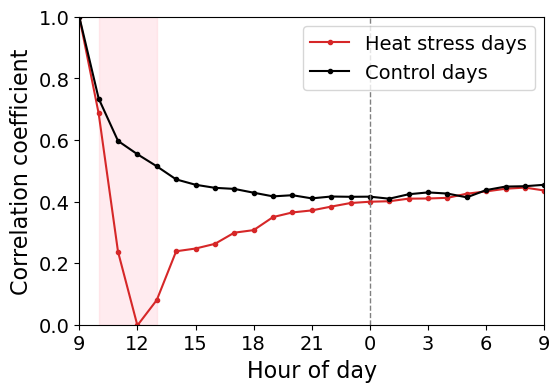

In [25]:
tpx = np.arange(starthour,starthour+numhoursforward)
f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)
ax.plot(tpx,heatcorr,marker='.',label='Heat stress days',color=bp.snscolors[3])
ax.plot(tpx,comparecorr,marker='.',label='Control days',color='k')
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylim([0,1])
ax.set_xlim([tpx[0],tpx[-1]])
ax.set_xticks(tpx[::3])
ax.set_xticklabels(np.mod(tpx[::3],24))
ax.axvline(24,linewidth=1,color='grey',linestyle='--')
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_xlabel('Hour of day',fontsize=16)
ax.axvspan(10,13,alpha=0.3,color='pink')

plt.savefig('../image-output/corr-time.pdf')

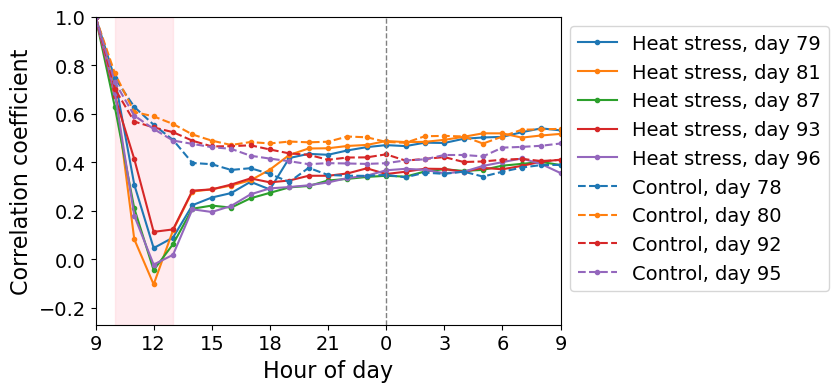

In [35]:
tpx = np.arange(starthour,starthour+numhoursforward)
f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)

for i,ic in enumerate(range(5)):
    ax.plot(tpx,heatcorr_pertrial[:,i],marker='.',label='Heat stress, day '+str(treatmentdays[i]),color=bp.snscolors[ic],linestyle='-')

for i,ic in enumerate([0,1,3,4]):
    ax.plot(tpx,comparecorr_pertrial[:,i],marker='.',label='Control, day '+str(corrcomparedays[i]),color=bp.snscolors[ic],linestyle='--')

ax.legend(fontsize=14,bbox_to_anchor=(1,1))
ax.tick_params(labelsize=14)
ax.set_ylim([-0.27,1])
ax.set_xlim([tpx[0],tpx[-1]])
ax.set_xticks(tpx[::3])
ax.set_xticklabels(np.mod(tpx[::3],24))
ax.axvline(24,linewidth=1,color='grey',linestyle='--')
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_xlabel('Hour of day',fontsize=16)
ax.axvspan(10,13,alpha=0.3,color='pink')
plt.show()

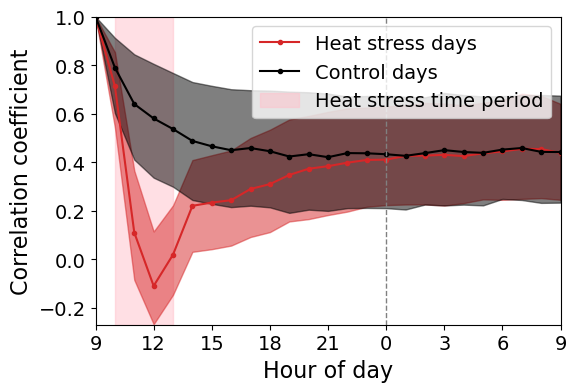

In [26]:
tpx = np.arange(starthour,starthour+numhoursforward)
f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)
# ax.plot(tpx,heatcorr,marker='.',label='Heat stress days',color=bp.snscolors[3])
ax.plot(tpx,np.nanmedian(heatcorr_perbee,axis=-1),marker='.',color=bp.snscolors[3],label='Heat stress days')
ax.fill_between(tpx,np.nanquantile(heatcorr_perbee,0.25,axis=-1),np.nanquantile(heatcorr_perbee,0.75,axis=-1),color=bp.snscolors[3],alpha=0.5)
# ax.plot(tpx,comparecorr,marker='.',label='Control days',color='k')
ax.plot(tpx,np.nanmedian(comparecorr_perbee,axis=-1),marker='.',label='Control days',color='k')
ax.fill_between(tpx,np.nanquantile(comparecorr_perbee,0.25,axis=-1),np.nanquantile(comparecorr_perbee,0.75,axis=-1),color='k',alpha=0.5)
ax.tick_params(labelsize=14)
ax.set_ylim([-0.27,1])
ax.set_xlim([tpx[0],tpx[-1]])
ax.set_xticks(tpx[::3])
ax.set_xticklabels(np.mod(tpx[::3],24))
ax.axvline(24,linewidth=1,color='grey',linestyle='--')
ax.set_ylabel('Correlation coefficient',fontsize=16)
ax.set_xlabel('Hour of day',fontsize=16)
ax.axvspan(10,13,alpha=0.5,color='pink',zorder=-10,label='Heat stress time period')
ax.legend(fontsize=14)
plt.savefig('../image-output/corr-perbee.pdf')
plt.show()

# Cohort groupings - histogram for each heat stress trial

In [131]:
cohorts_to_plot = np.unique(dfsel['Cohort ID']).astype(int)

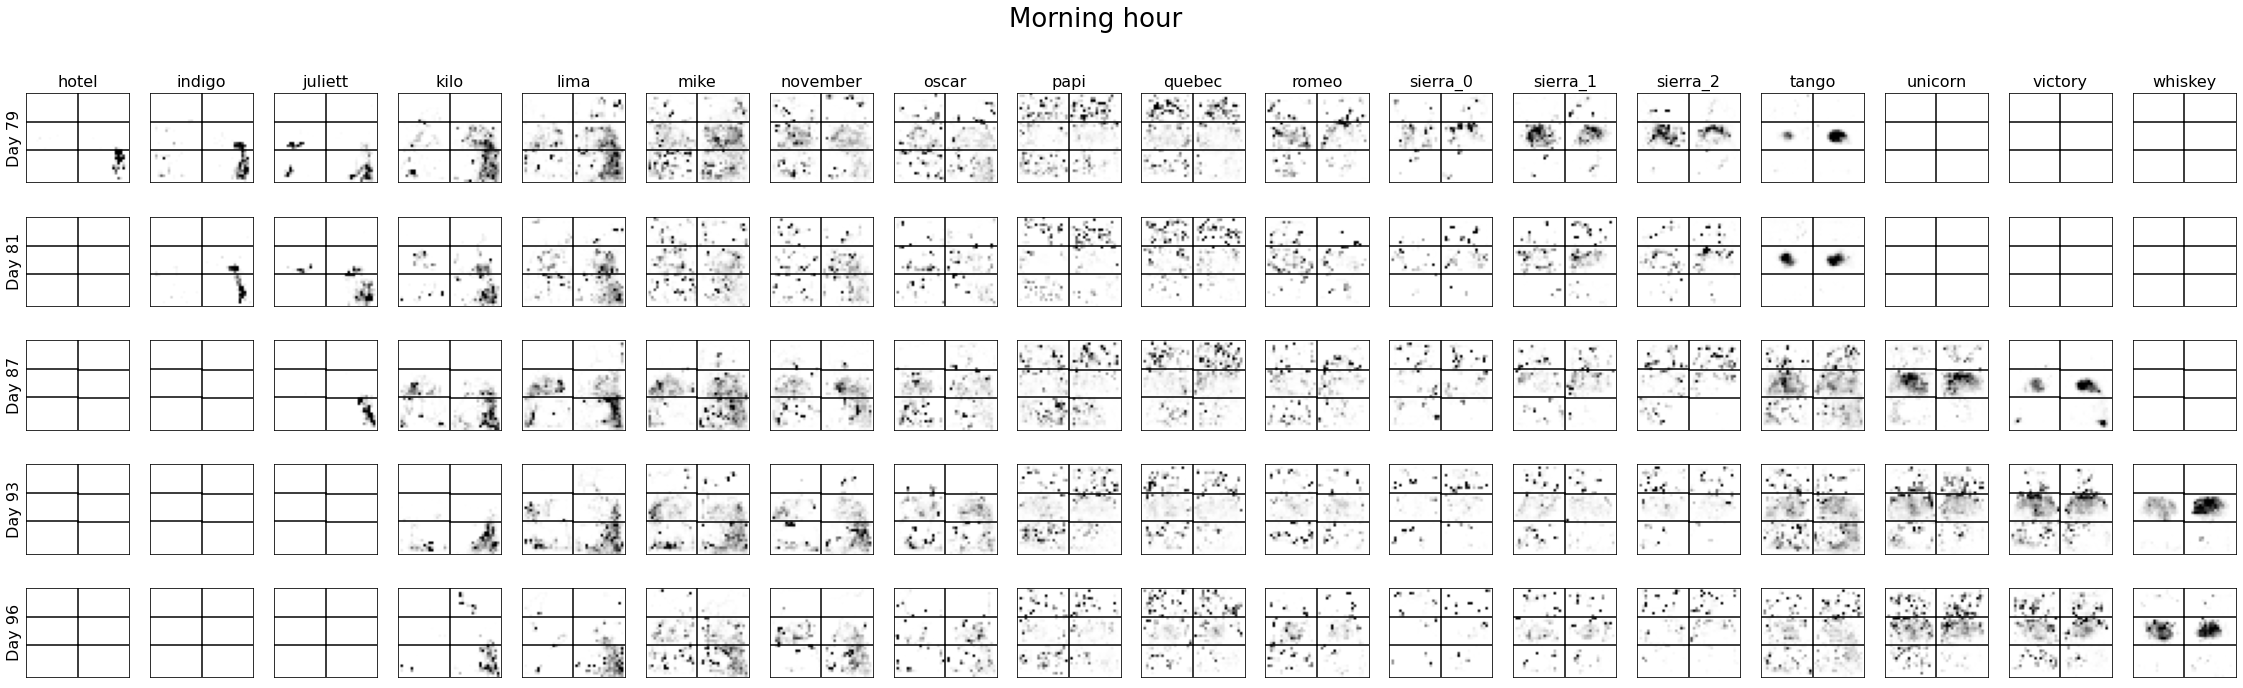

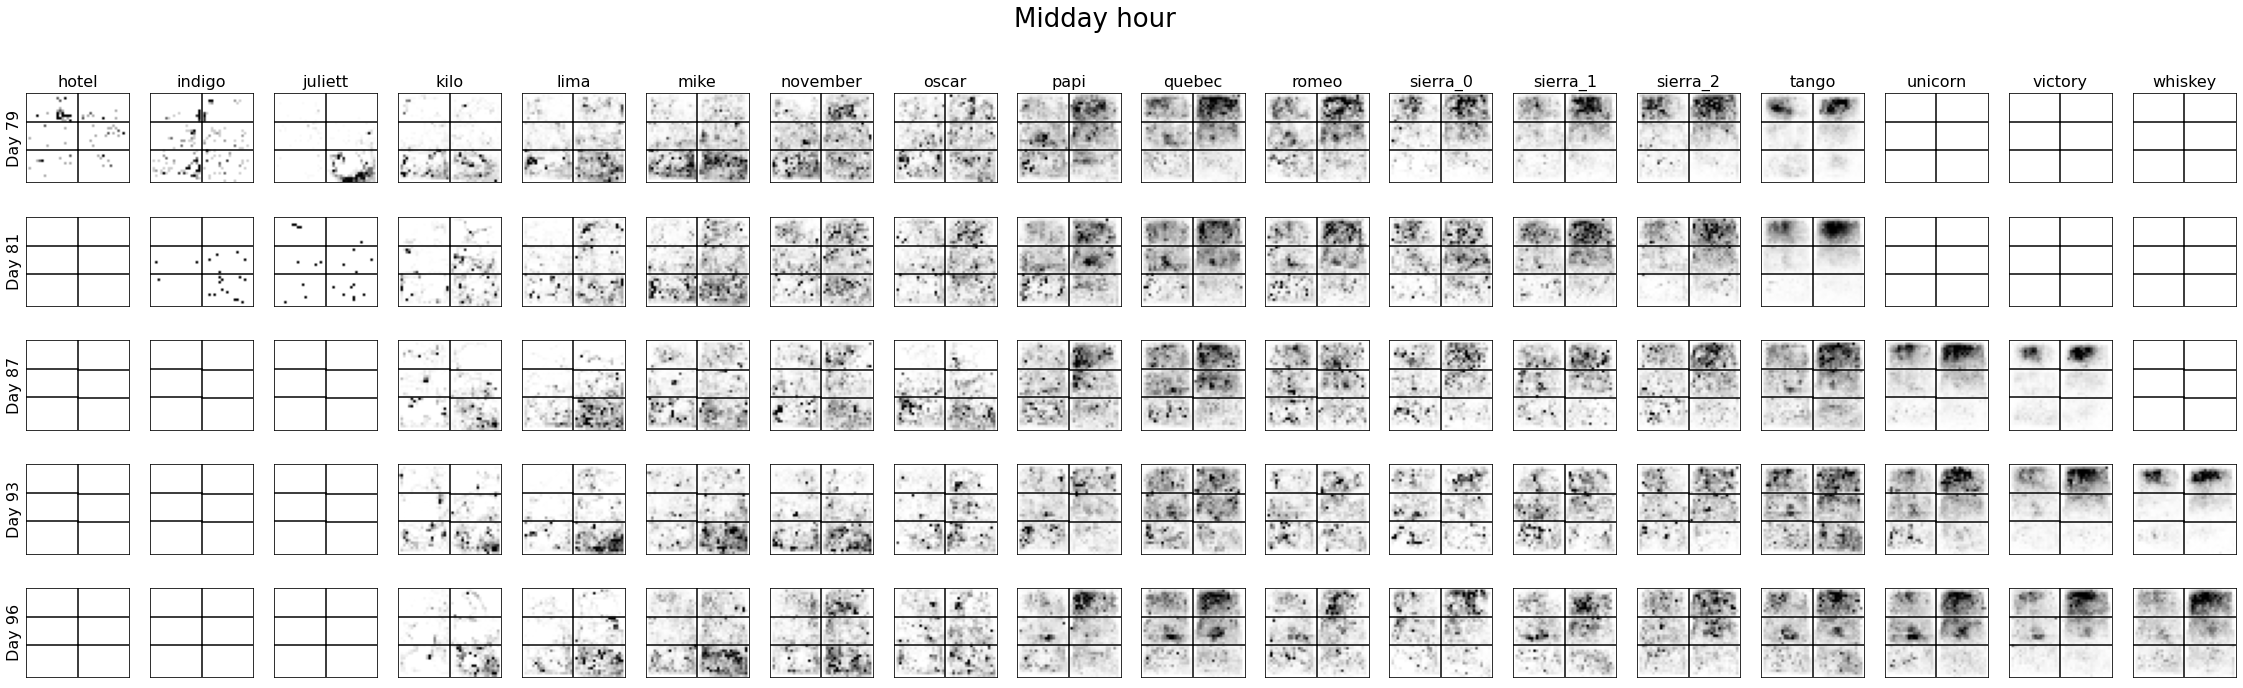

In [133]:
numtoshow=len(cohorts_to_plot)

for whichhour,title in zip([morninghour,middayhour],["Morning hour","Midday hour"]):

    f,ax = plt.subplots(len(treatmentdays),numtoshow,sharex=True,sharey=True)
    basesize=2.2
    f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0])
    f.set_facecolor('white')

    for i,daynum in enumerate(treatmentdays):
        ax[i,0].set_ylabel('Day '+str(daynum),fontsize=16)
        for j,cid in enumerate(cohorts_to_plot[0:numtoshow]):
            a=ax[i,j]
            if i==0:
                 a.set_title(bd.cohort_names[cid],fontsize=16)
            sel = (dfxysel['Hour']==whichhour) & (dfxysel['Cohort ID']==cid) & (dfxysel['Day number']==daynum)
            tphist = dfunc.flat_to_hist(np.mean(dfxysel[sel],axis=0))
            # print(np.quantile(tphist,0.99))
            bp.showframe(a,color='k')
            bp.showhist(tphist,ax=a,normvalue=-1)
    plt.suptitle(title,fontsize=26)
    plt.show()